#Configuración de ambiente

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Instalamos Massive api pra extraer datos financieros
# Instalamos bar_chart_race para la creación de graficos de carreras de barras

!pip install -U massive
!pip install bar_chart_race

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 10.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import os
from google.colab import userdata
from massive import RESTClient
from datetime import datetime
import bar_chart_race as bcr
import warnings

In [5]:
# Versiones al momento de la ejecución y versiones usadas al momento de la creación de este codigo

!python -V  # Python 3.11.13
print('------')
!pip show Pandas | grep 'Name\|Version'  # pandas Version: 2.2.2
print('------')
!pip show Numpy | grep 'Name\|Version'   # numpy Version: 2.0.2
print('------')
!pip show Matplotlib | grep 'Name\|Version'  # matplotlib Version: 3.10.0
print('------')
!pip show plotly | grep 'Name\|Version'  # plotly Version: 5.24.1
print('------')
!pip show seaborn | grep 'Name\|Version' # seaborn Version: 0.13.2
print('------')
!pip show massive | grep 'Name\|Version'  # massive Version: 1.15.3
print('------')
!pip show bar_chart_race | grep 'Name\|Version'  # bar-chart-race Version: 0.1.0
print('------')


Python 3.12.12
------
Name: pandas
Version: 2.2.2
------
Name: numpy
Version: 2.0.2
Name: lapack-lite
Name: dragon4
Name: libdivide
Name: Meson
Name: spin
Name: OpenBLAS
Name: LAPACK
Name: GCC runtime library
Version 3.1, 31 March 2009
                       Version 3, 29 June 2007
  5. Conveying Modified Source Versions.
  14. Revised Versions of this License.
Name: libquadmath
------
Name: matplotlib
Version: 3.10.0
------
Name: plotly
Version: 5.24.1
------
Name: seaborn
Version: 0.13.2
------
Name: massive
Version: 2.0.1
------
Name: bar-chart-race
Version: 0.1.0
------


#Obtención de datos

##Importando datos (Forbes Global 2008-2023 / Fortune Global 500 / Continentes y Paises)

In [6]:
carpeta_forbes_global = '/content/drive/MyDrive/Alura/Challenge Data Insider/aroissues-forbes-global-2000-2008-2019/'
carpeta_continentes_paises = '/content/drive/MyDrive/Alura/Challenge Data Insider/continentes_y_paises/'
carpeta_fortune_global = '/content/drive/MyDrive/Alura/Challenge Data Insider/fortune_global_500/'


def leer_archivos(carpeta:str):

    """
    La funcion obtiene la direccion de una carpeta e importa todos los datos a una lista de dataframes

    arg:
        carpeta (str): direccion de la carpeta donde se encuentran los archivos

    return:
        datos (list): lista de dataframes con los datos importados

    raise:
        Exception: si ocurre un error al importar el archivo
        seguramente sean excepciones relacionadas con la funcion
        pd.read_html() (ValueError, FileNotFoundError, urllib.error.URLError,
        urllib.error.URLError)

    """
    datos = []
    for archivo in os.listdir(carpeta):
        ruta_completa = os.path.join(carpeta, archivo)

        if os.path.isfile(ruta_completa):
          try:
            if archivo.endswith('.csv'):
              df = pd.read_csv(ruta_completa)
              datos.append(df)
              print(f"Archivo {archivo} importado correctamente.")
            elif archivo.endswith('.xlsx'):
              df = pd.read_excel(ruta_completa)
              datos.append(df)
              print(f"Archivo {archivo} importado correctamente.")
            else:
              df = pd.read_html(ruta_completa)
              df = pd.DataFrame(df[0])
              datos.append(df)
              print(f"Archivo {archivo} importado correctamente.")
          except Exception as e:
            print(f"Error al importar el archivo {archivo}: {e}")
    return datos


In [7]:
datos_forbes_global = leer_archivos(carpeta_forbes_global)
datos_continentes_paises = leer_archivos(carpeta_continentes_paises)
datos_fortune = leer_archivos(carpeta_fortune_global)

Archivo Forbes Global 2000 - 2009 — unified industry.xlsx importado correctamente.
Archivo Forbes Global 2000 - 2008 — unified industry.xlsx importado correctamente.
Archivo Forbes Global 2000 - 2010 — unified industry.xlsx importado correctamente.
Archivo Forbes Global 2000 - 2011 — unified industry.xlsx importado correctamente.
Archivo Forbes Global 2000 - 2014 — unified industry.xlsx importado correctamente.
Archivo Forbes Global 2000 - 2015 — unified industry.xlsx importado correctamente.
Archivo Forbes Global 2000 - 2013 — unified industry.xlsx importado correctamente.
Archivo Forbes Global 2000 - 2012 — unified industry.xlsx importado correctamente.
Archivo Forbes Global 2000 - 2016 — unified industry.xlsx importado correctamente.
Archivo Forbes Global 2000 - 2022 — unified industry.xlsx importado correctamente.
Archivo Forbes Global 2000 - 2021 — unified industry.xlsx importado correctamente.
Archivo Forbes Global 2000 - 2020 — unified industry.xlsx importado correctamente.
Arch

##Importando y exportando datos Massive

In [ ]:
# Obtenemos la llave para acceder a la API
client = RESTClient(userdata.get('MASSIVE_API_KEY'))

# Define una lista de tickers de las empresas
tickers_empresas = ["NTDOF", "EA", "KONMY", "SQNXF", "UBSFF"]

# Crea un diccionario para almacenar los datos
datos_historicos_estructurados = {}

# Itera sobre los tickers y obtén los datos históricos
for ticker in tickers_empresas:
  try:
    # Obtiene los datos agregados diarios para el rango de fechas deseado
    resp = client.get_aggs(ticker, 1, "day", "2024-01-01", "2024-12-31")

    # Procesa la respuesta para extraer los datos específicos
    datos_empresa = []
    if resp: # Verifica si la respuesta no está vacía
      for agg in resp:
        # Convierte el timestamp a un formato de fecha legible (Massive obtiene los datos de fecha en milisegundos)
        fecha = datetime.fromtimestamp(agg.timestamp / 1000)
        fecha = fecha.strftime('%d-%m-%Y')
        # Ahora la fecha se almacena como dato tipo object, entonces la convertimos a un dato tipo datetime
        fecha = pd.to_datetime(fecha, format='%d-%m-%Y')
        # Generamos una lista que almacenará los datos de cada ticker en forma de diccionario
        datos_empresa.append({
            "Symbol": ticker,
            "Fecha": fecha,
            "Precio_Apertura": agg.open,
            "Precio_Cierre": agg.close,
            "Precio_Maximo": agg.high,
            "Precio_Minimo": agg.low
        })
    # Se almacenan los datos en el diccionario
    datos_historicos_estructurados[ticker] = datos_empresa
    print(f"Datos históricos de {ticker} obtenidos exitosamente.")
  except Exception as e:
    print(f"Error al obtener y procesar datos para {ticker}: {e}")

Datos históricos de NTDOF obtenidos exitosamente.
Datos históricos de EA obtenidos exitosamente.
Datos históricos de KONMY obtenidos exitosamente.
Datos históricos de SQNXF obtenidos exitosamente.
Datos históricos de UBSFF obtenidos exitosamente.


In [9]:
print(datos_historicos_estructurados['NTDOF'])

[{'Symbol': 'NTDOF', 'Fecha': Timestamp('2024-01-02 00:00:00'), 'Precio_Apertura': 53.04, 'Precio_Cierre': 51.3485, 'Precio_Maximo': 53.04, 'Precio_Minimo': 50.61}, {'Symbol': 'NTDOF', 'Fecha': Timestamp('2024-01-03 00:00:00'), 'Precio_Apertura': 51.01, 'Precio_Cierre': 51, 'Precio_Maximo': 51.568, 'Precio_Minimo': 50.965}, {'Symbol': 'NTDOF', 'Fecha': Timestamp('2024-01-04 00:00:00'), 'Precio_Apertura': 51.129, 'Precio_Cierre': 49.75, 'Precio_Maximo': 51.41, 'Precio_Minimo': 48.6}, {'Symbol': 'NTDOF', 'Fecha': Timestamp('2024-01-05 00:00:00'), 'Precio_Apertura': 49.93, 'Precio_Cierre': 50.5, 'Precio_Maximo': 50.653, 'Precio_Minimo': 49.88}, {'Symbol': 'NTDOF', 'Fecha': Timestamp('2024-01-08 00:00:00'), 'Precio_Apertura': 52.26, 'Precio_Cierre': 50.82, 'Precio_Maximo': 52.26, 'Precio_Minimo': 50.22}, {'Symbol': 'NTDOF', 'Fecha': Timestamp('2024-01-09 00:00:00'), 'Precio_Apertura': 50.1, 'Precio_Cierre': 52, 'Precio_Maximo': 52.722, 'Precio_Minimo': 50.1}, {'Symbol': 'NTDOF', 'Fecha': T

In [10]:
# Convertimos los datos de cada empresa a dataframes

df_nintendo = pd.DataFrame(datos_historicos_estructurados['NTDOF'])
df_ea = pd.DataFrame(datos_historicos_estructurados['EA'])
df_konami = pd.DataFrame(datos_historicos_estructurados['KONMY'])
df_squarenix = pd.DataFrame(datos_historicos_estructurados['SQNXF'])
df_ubisoft = pd.DataFrame(datos_historicos_estructurados['UBSFF'])


In [11]:
df_ubisoft.head()

Symbol      Fecha  Precio_Apertura  Precio_Cierre  Precio_Maximo  \
0  UBSFF 2024-01-05            24.25          24.25          24.25   
1  UBSFF 2024-01-10            24.85          24.85          24.85   
2  UBSFF 2024-01-11            24.30          23.80          24.30   
3  UBSFF 2024-01-16            23.44          23.44          23.44   
4  UBSFF 2024-01-17            21.83          21.83          21.83   

   Precio_Minimo  
0          24.25  
1          24.85  
2          23.80  
3          23.44  
4          21.83

In [12]:
# Creamos un dataframe general con todos los datos

df_massive = pd.concat([df_nintendo, df_ea, df_konami, df_squarenix, df_ubisoft])

df_massive.to_csv('datos_massive.csv', index=False)

In [13]:
display(df_massive.head(),df_massive.info())

<class 'pandas.core.frame.DataFrame'>
Index: 799 entries, 0 to 135
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Symbol           799 non-null    object        
 1   Fecha            799 non-null    datetime64[ns]
 2   Precio_Apertura  799 non-null    float64       
 3   Precio_Cierre    799 non-null    float64       
 4   Precio_Maximo    799 non-null    float64       
 5   Precio_Minimo    799 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 43.7+ KB


Symbol      Fecha  Precio_Apertura  Precio_Cierre  Precio_Maximo  \
0  NTDOF 2024-01-02           53.040        51.3485         53.040   
1  NTDOF 2024-01-03           51.010        51.0000         51.568   
2  NTDOF 2024-01-04           51.129        49.7500         51.410   
3  NTDOF 2024-01-05           49.930        50.5000         50.653   
4  NTDOF 2024-01-08           52.260        50.8200         52.260   

   Precio_Minimo  
0         50.610  
1         50.965  
2         48.600  
3         49.880  
4         50.220

None

In [14]:
# Exportamos los datos en formato .csv

df_nintendo.to_csv('datos_nintendo_2024.csv', index=False)
df_ea.to_csv('datos_ea_2024.csv', index=False)
df_konami.to_csv('datos_konami_2024.csv', index=False)
df_squarenix.to_csv('datos_squarenix_2024.csv', index=False)
df_ubisoft.to_csv('datos_ubisoft_2024.csv', index=False)

#Data Wrangling

##Datos Forbes

In [15]:
# iteramos en la lista de dataframes y renombramos las columnas

for df in datos_forbes_global:
  df.rename(columns={'Company': 'Empresa', 'Industry':'Industria',
                     'Country':'Pais', 'Sales':'Ingresos', 'Profits':'Ganancias',
                     'Assets':'Activos', 'Market_Value':'Valor_de_mercado'}, inplace=True)

# Añadimos 2 nuevas columnas
  df['Margen_de_rentabilidad (%)'] = round((df['Ganancias'] / df['Ingresos'])*100,2)
  df['ROA (%)'] = round((df['Ganancias'] / df['Activos'])*100,2)


In [16]:
# Añadimos la columna año, siguiendo el orden en el que se importaron
# lo hacemos de esta forma porque no se importaron con un orden especifico
# de lo contrario, usariamos un ciclo for

datos_forbes_global[0]['Ano'] = 2009
datos_forbes_global[1]['Ano'] = 2008
datos_forbes_global[2]['Ano'] = 2010
datos_forbes_global[3]['Ano'] = 2011
datos_forbes_global[4]['Ano'] = 2014
datos_forbes_global[5]['Ano'] = 2015
datos_forbes_global[6]['Ano'] = 2013
datos_forbes_global[7]['Ano'] = 2012
datos_forbes_global[8]['Ano'] = 2016
datos_forbes_global[9]['Ano'] = 2022
datos_forbes_global[10]['Ano'] = 2021
datos_forbes_global[11]['Ano'] = 2020
datos_forbes_global[12]['Ano'] = 2019
datos_forbes_global[13]['Ano'] = 2018
datos_forbes_global[14]['Ano'] = 2023
datos_forbes_global[15]['Ano'] = 2017

In [17]:
datos_forbes_global[0].head()

Rank_nr            Empresa             Industria            Pais  Ingresos  \
0        1   General Electric         Conglomerates   United States  182520.0   
1        2  Royal Dutch Shell  Oil & Gas Operations     Netherlands  458360.0   
2        3       Toyota Motor     Consumer Durables           Japan  263420.0   
3        4         ExxonMobil  Oil & Gas Operations   United States  425700.0   
4        5                 BP  Oil & Gas Operations  United Kingdom  361140.0   

   Ganancias   Activos  Valor_de_mercado  Margen_de_rentabilidad (%)  ROA (%)  \
0    17410.0  797770.0           89870.0                        9.54     2.18   
1    26280.0  278440.0          135100.0                        5.73     9.44   
2    17210.0  324980.0          102350.0                        6.53     5.30   
3    45220.0  228050.0          335540.0                       10.62    19.83   
4    21160.0  228240.0          119700.0                        5.86     9.27   

    Ano  
0  2009  
1  2009  
2  2009  
3  2009  
4  2009

##Datos Fortune Global 500

In [18]:
# Imprimimos los nombres de las columnas de cada dataframe
# Esto porque hay inconsistencias en los nombres de las columnas
# De esta forma podemos identificar algún elemento común para agilizar
# el proceso de eliminación de columnas
for df in datos_fortune:
  print(df.columns)

Index(['RemoveRank', 'RemoveName', 'RemoveRevenues ($M)',
       'RemoveRevenue Percent Change', 'RemoveProfits ($M)',
       'RemoveAssets ($M)', 'RemoveProfits Percent Change', 'RemoveEmployees',
       'RemoveChange in Rank', 'RemoveCountry / Territory'],
      dtype='object')
Index(['RemoveRank', 'RemoveName', 'RemoveRevenues ($M)',
       'RemoveRevenue Percent Change', 'RemoveProfits ($M)',
       'RemoveProfits Percent Change', 'RemoveAssets ($M)', 'RemoveEmployees',
       'RemoveChange in Rank', 'RemoveYears on Global 500 List'],
      dtype='object')
Index(['RemoveRank', 'RemoveName', 'RemoveRevenues ($M)',
       'RemoveRevenue Percent Change', 'RemoveProfits ($M)',
       'RemoveProfits Percent Change', 'RemoveAssets ($M)', 'RemoveEmployees',
       'RemoveChange in Rank', 'RemoveYears on Global 500 List'],
      dtype='object')
Index(['RemoveRank', 'RemoveName', 'RemoveRevenues',
       'RemoveRevenue Percent Change', 'RemoveProfits', 'RemoveAssets',
       'RemoveEmployee

In [19]:
# Renombramos las columnas que deseamos mantener y eliminamos el resto

for df in datos_fortune:
  df.rename(columns={'RemoveName':'Empresa', 'RemoveEmployees':'Empleados'}, inplace=True)
  df.drop([columna for columna in df.columns if 'Remove' in columna], inplace=True, axis=1)
datos_fortune[0].head()

Empresa  Empleados
0                   Walmart    2200000
1             Sinopec Group     619151
2         Royal Dutch Shell      81000
3  China National Petroleum    1382401
4                State Grid     917717

In [20]:
# Al igual que en el caso anterior, añadimos la columna año de forma manual

datos_fortune[0]['Ano'] = 2019
datos_fortune[1]['Ano'] = 2021
datos_fortune[2]['Ano'] = 2020
datos_fortune[3]['Ano'] = 2015
datos_fortune[4]['Ano'] = 2017
datos_fortune[5]['Ano'] = 2018
datos_fortune[6]['Ano'] = 2016
datos_fortune[7]['Ano'] = 2022

In [21]:
datos_fortune[7].head()

Empresa  Empleados   Ano
0                   Walmart    2300000  2022
1                    Amazon    1608000  2022
2                State Grid     871145  2022
3  China National Petroleum    1090345  2022
4             Sinopec Group     542286  2022

##Datos Continente_Pais

In [22]:
datos_continentes_paises[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Country  222 non-null    object
 1   Code     222 non-null    object
dtypes: object(2)
memory usage: 3.6+ KB


In [23]:
# Renombramos nombres de columnas

datos_continentes_paises[0].rename(columns={'Country':'Pais', 'Code':'Codigo'}, inplace=True)

In [24]:
datos_continentes_paises[0].head()

Pais Codigo
0     Afghanistan    AFG
1         Albania    ALB
2         Algeria    DZA
3  American Samoa    ASM
4         Andorra    AND

In [25]:
datos_continentes_paises[1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Continent_Name             258 non-null    object
 1   Continent_Code             215 non-null    object
 2   Three_Letter_Country_Code  258 non-null    object
 3   Country_Name               258 non-null    object
dtypes: object(4)
memory usage: 8.2+ KB


In [26]:
# Renombramos nombres de columnas

datos_continentes_paises[1].rename(columns={'Continent_Name':'Continente',
                                            'Three_Letter_Country_Code':'Codigo',
                                            'Country_Name':'Pais'}, inplace=True)
datos_continentes_paises[1].drop('Continent_Code', inplace=True, axis=1)

In [27]:
datos_continentes_paises[1].head()

Continente Codigo                                          Pais
0        Asia    AFG              Afghanistan, Islamic Republic of
1      Europe    ALB                          Albania, Republic of
2  Antarctica    ATA  Antarctica (the territory South of 60 deg S)
3      Africa    DZA      Algeria, People's Democratic Republic of
4     Oceania    ASM                                American Samoa

In [28]:
datos_continentes_paises[1]['Continente'].unique()

array(['Asia', 'Europe', 'Antarctica', 'Africa', 'Oceania',
       'North America', 'South America'], dtype=object)

#Junción de tablas y analisis exploratorio

## Junción y análisis continentes_paises


In [29]:
# Unificamos los datos de la lista datos_continentes_paises en un solo dataframe

df_paises_continentes = pd.merge(datos_continentes_paises[0], datos_continentes_paises[1], how='outer', on='Codigo')


df_paises_continentes = df_paises_continentes[['Pais_x', 'Codigo', 'Continente']].rename(columns={'Pais_x': 'Pais'})


display(df_paises_continentes.info(), df_paises_continentes.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Pais        229 non-null    object
 1   Codigo      262 non-null    object
 2   Continente  259 non-null    object
dtypes: object(3)
memory usage: 6.3+ KB


None

Pais Codigo  Continente
131      Kuwait    KWT        Asia
40          NaN    BVT  Antarctica
117       Italy    ITA      Europe
28      Bahrain    BHR        Asia
179        Oman    OMN        Asia
236      Turkey    TUR        Asia
125  Kyrgyzstan    KGZ        Asia
77      Finland    FIN      Europe
119      Jersey    JEY      Europe
146      Monaco    MCO      Europe

In [30]:
df_paises_continentes.loc[df_paises_continentes['Pais'].isnull()]

Pais Codigo     Continente
4    NaN    ALA         Europe
7    NaN    ANT  North America
13   NaN    ATA     Antarctica
14   NaN    ATF     Antarctica
23   NaN    BES  North America
29   NaN    BHS  North America
31   NaN    BLM  North America
40   NaN    BVT     Antarctica
44   NaN    CCK           Asia
59   NaN    CXR           Asia
73   NaN    ESH         Africa
91   NaN    GLP  North America
99   NaN    GUF  South America
103  NaN    HMD     Antarctica
111  NaN    IOT           Asia
161  NaN    MSR  North America
162  NaN    MTQ  North America
166  NaN    MYT         Africa
170  NaN    NFK        Oceania
177  NaN    NRU        Oceania
182  NaN    PCN        Oceania
192  NaN    PSE           Asia
195  NaN    REU         Africa
204  NaN    SGS     Antarctica
205  NaN    SHN         Africa
206  NaN    SJM         Europe
224  NaN    TCA  North America
229  NaN    TKL        Oceania
242  NaN    UMI        Oceania
243  NaN    UMI  North America
247  NaN    VAT         Europe
252  NaN    VIR  North America
256  NaN    WLF        Oceania

In [31]:
#Verificamos los duplicados y evaluamos si debemos eliminarlos o no

df_paises_continentes.loc[df_paises_continentes['Codigo'].duplicated(keep=False)]

Pais Codigo     Continente
10                  Armenia    ARM         Europe
11                  Armenia    ARM           Asia
18               Azerbaijan    AZE         Europe
19               Azerbaijan    AZE           Asia
61                   Cyprus    CYP         Europe
62                   Cyprus    CYP           Asia
85                  Georgia    GEO         Europe
86                  Georgia    GEO           Asia
122              Kazakhstan    KAZ         Europe
123              Kazakhstan    KAZ           Asia
197                  Russia    RUS         Europe
198                  Russia    RUS           Asia
235                  Turkey    TUR         Europe
236                  Turkey    TUR           Asia
242                     NaN    UMI        Oceania
243                     NaN    UMI  North America
250  British Virgin Islands    VGB  North America
251          Virgin Islands    VGB  North America

In [32]:
# Eliminamos los duplicados para facilitar la operacion de llenado de datos nulos en la columna 'Pais'

df_paises_continentes.drop_duplicates(subset='Codigo', inplace=True)

In [33]:
# Creamos un dataframe con los datos faltantes y los introducimos en el dataframe original usando la columna codigo como indice
paises_faltantes = {'Codigo': ['ALA', 'ANT', 'ATA', 'ATF', 'BES', 'BHS', 'BLM', 'BVT', 'CCK', 'CXR', 'ESH', 'GLP', 'GUF', 'HMD', 'IOT', 'MSR', 'MTQ', 'MYT', 'NFK', 'NRU', 'PCN', 'PSE', 'REU', 'SGS', 'SHN', 'SJM', 'TCA', 'TKL', 'UMI', 'VAT', 'VIR', 'WLF'],
        'Pais': ['Åland Islands', 'Antigua and Barbuda', 'Antarctica', 'French Southern Territories', 'Bonaire, Sint Eustatius and Saba', 'Bahamas (the)', 'Saint Barthélemy', 'Bouvet Island', 'Cocos (Keeling) Islands (the)', 'Christmas Island', 'Western Sahara',
                    'Guadeloupe', 'French Guiana', 'Heard Island and McDonald Islands', 'British Indian Ocean Territory (the)', 'Montserrat', 'Martinique', 'Mayotte', 'Norfolk Island', 'Nauru', 'Pitcairn', 'Palestine, State of', 'Réunion', 'South Georgia and the South Sandwich Islands',
                    'Saint Helena, Ascension and Tristan da Cunha', 'Svalbard and Jan Mayen', 'Turks and Caicos Islands (the)', 'Tokelau', 'United States Minor Outlying Islands (the)', 'Holy See (the)', 'Virgin Islands (U.S.)', 'Wallis and Futuna']}

df = pd.DataFrame(paises_faltantes)
df.set_index('Codigo', inplace=True)
df_paises_continentes.set_index('Codigo', inplace=True)

df_paises_continentes['Pais'] = df_paises_continentes['Pais'].fillna(df['Pais'])

df_paises_continentes.reset_index(inplace=True)
df_paises_continentes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Codigo      253 non-null    object
 1   Pais        253 non-null    object
 2   Continente  250 non-null    object
dtypes: object(3)
memory usage: 6.1+ KB


In [34]:
# Observamos cuales son los valores nulos que faltan por solucionar
df_paises_continentes.loc[df_paises_continentes['Continente'].isnull()]

Codigo          Pais Continente
25     BHM  Bahamas, The        NaN
125    KSV        Kosovo        NaN
246    WBG     West Bank        NaN

In [35]:
# Cambiamos el codigo KSV, este ya no se usa, ahora se utiliza XKX

df_paises_continentes.loc[df_paises_continentes['Codigo'] == 'KSV', 'Continente'] = 'Europe'

# Eliminamos el resto de valores, pues no pertenecen a ningun país
df_paises_continentes.dropna(inplace=True)

df_paises_continentes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251 entries, 0 to 252
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Codigo      251 non-null    object
 1   Pais        251 non-null    object
 2   Continente  251 non-null    object
dtypes: object(3)
memory usage: 7.8+ KB


## Junción y análisis forbes 2000

In [36]:
# unificamos los dataframes Forbes 2000 en el periodo solicitado para trabajar las preguntas que debemos resolver

# Dataframe de los datos en el periodo 2015 - 2022
df_forbes_2015_2022 = pd.concat([df for df in datos_forbes_global if df['Ano'].iloc[0] >= 2015 and df['Ano'].iloc[0] <= 2022])

In [37]:
df_forbes_2015_2022['Industria'].unique()

array(['Banking', 'Diversified Financials', 'Oil & Gas Operations',
       'Conglomerates', 'Consumer Durables',
       'Technology Hardware & Equipment', 'Retailing', 'Semiconductors',
       'Telecommunications services', 'Insurance',
       'IT Software & Services', 'Food, Drink & Tobacco',
       'Health Care Equipment & Services', 'Media',
       'Drugs & Biotechnology', 'Diversified Metals & Mining',
       'Utilities', 'Chemicals', 'Aerospace & Defense', 'Construction',
       'Trading Companies', 'Capital Goods', 'Transportation',
       'Air Courier', 'Real Estate', 'Hotels, Restaurants & Leisure',
       'Airline', 'Business Services & Supplies', 'Food Markets',
       'Casinos & Gaming', 'Materials', 'Telecommunications Services'],
      dtype=object)

In [38]:
df_forbes_2015_2022['Industria'].loc[df_forbes_2015_2022['Industria'] == 'Telecommunications services'] = 'Telecommunications Services'

/tmp/ipython-input-2018460038.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_forbes_2015_2022['Industria'].loc[df_forbes_2015_2022['Industria'] == 'Telecommunications services'] = 'Telecommunications Services'
/tmp/ipython-input-2018

In [39]:
# Iniciamos el análisis exploratorio del dataset para buscar datos nulos, faltantes e incongruentes
display(df_forbes_2015_2022.info(), df_forbes_2015_2022.describe().round(2))

<class 'pandas.core.frame.DataFrame'>
Index: 15998 entries, 0 to 1998
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Rank_nr                     15998 non-null  object 
 1   Empresa                     15998 non-null  object 
 2   Industria                   15998 non-null  object 
 3   Pais                        15998 non-null  object 
 4   Ingresos                    15990 non-null  float64
 5   Ganancias                   15996 non-null  float64
 6   Activos                     15983 non-null  float64
 7   Valor_de_mercado            15992 non-null  float64
 8   Margen_de_rentabilidad (%)  15988 non-null  float64
 9   ROA (%)                     15982 non-null  float64
 10  Ano                         15998 non-null  int64  
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


None

Ingresos  Ganancias     Activos  Valor_de_mercado  \
count   15990.00   15996.00    15983.00          15992.00   
mean    19984.14    1582.74    95576.18          29093.82   
std     34510.61    4127.48   298539.15          74695.22   
min     -9140.00  -23119.00        1.00              9.00   
25%      4437.00     371.78    11993.50           6635.75   
50%      9882.00     718.95    25763.00          13181.50   
75%     19869.75    1554.28    62092.50          27678.00   
max    572754.00  105363.00  5518508.00        2640316.00   

       Margen_de_rentabilidad (%)   ROA (%)       Ano  
count                    15988.00  15982.00  15998.00  
mean                          inf      5.58   2018.50  
std                           NaN     73.18      2.29  
min                     -11224.81   -211.92   2015.00  
25%                          3.69      0.88   2017.00  
50%                          9.27      3.06   2019.00  
75%                         18.11      6.96   2020.75  
max                           inf   8695.21   2022.00

In [40]:
#Se observan irregularidades en la relación de ganancias respecto a los ingresos, lo cual se refleja en el margen de rentabilidad

df_forbes_2015_2022.loc[df_forbes_2015_2022['Ganancias'] >= df_forbes_2015_2022['Ingresos']]

Rank_nr                       Empresa                    Industria  \
39        40                      Vodafone  Telecommunications Services   
466      467                         Yahoo       IT Software & Services   
501      502                  CK Hutchison                Conglomerates   
735      736                 Scentre Group       Diversified Financials   
747      749         Power Assets Holdings                    Utilities   
...      ...                           ...                          ...   
1845    1845  Merlin Properties SOCIMI S.A       Diversified Financials   
1858    1860                 Paramount Res         Oil & Gas Operations   
1896    1897                     Fabege AB                 Construction   
1969    1971     Tian An China Investments                 Construction   
1995    1996             Fastighets Balder       Diversified Financials   

                Pais  Ingresos  Ganancias   Activos  Valor_de_mercado  \
39    United Kingdom   66306.0    77401.4  200480.0           88035.0   
466    United States    4617.0     7521.7   61960.0           40880.0   
501        Hong Kong    3398.0     6946.6   59052.0           47621.0   
735        Australia    1959.0     5936.3   25706.0           15231.0   
747        Hong Kong     275.0     7866.9   17573.0           21390.0   
...              ...       ...        ...       ...               ...   
1845           Spain     401.0      644.5   11516.0            5426.0   
1858          Canada     186.0      879.5    1535.0            1407.0   
1896          Sweden     246.0      830.1    5528.0            2689.0   
1969       Hong Kong     244.0      736.0    4346.0            1229.0   
1995          Sweden     630.0      639.4   10196.0            3838.0   

      Margen_de_rentabilidad (%)  ROA (%)   Ano  
39                        116.73    38.61  2015  
466                       162.91    12.14  2015  
501                       204.43    11.76  2015  
735                       303.03    23.09  2015  
747                      2860.69    44.77  2015  
...                          ...      ...   ...  
1845                      160.72     5.60  2017  
1858                      472.85    57.30  2017  
1896                      337.44    15.02  2017  
1969                      301.64    16.94  2017  
1995                      101.49     6.27  2017  

[228 rows x 11 columns]

In [41]:
# Eliminamos todos los registros con ingresos menores a las ganancias

indices_a_eliminar = df_forbes_2015_2022.loc[df_forbes_2015_2022['Ganancias'] >= df_forbes_2015_2022['Ingresos']].index

df_forbes_2015_2022.drop(index=indices_a_eliminar, inplace=True)

In [42]:
df_forbes_2015_2022.describe().round(2)

Ingresos  Ganancias     Activos  Valor_de_mercado  \
count   14287.0   14292.00    14281.00          14289.00   
mean    21257.0    1667.89   102793.63          30959.16   
std     35965.7    4242.57   313053.10          78477.10   
min     -1193.0  -23119.00        1.00              9.00   
25%      4877.0     387.00    12617.00           6979.00   
50%     10529.0     747.20    27531.00          13967.00   
75%     21244.0    1662.55    66686.00          29615.00   
max    572754.0  105363.00  5518508.00        2640316.00   

       Margen_de_rentabilidad (%)   ROA (%)       Ano  
count                    14285.00  14280.00  14294.00  
mean                         9.77      4.63   2018.50  
std                        120.64     22.92      2.29  
min                     -11224.81   -211.92   2015.00  
25%                          3.74      0.89   2017.00  
50%                          9.15      3.01   2019.00  
75%                         17.62      6.77   2020.75  
max                        732.26   2594.59   2022.00

In [43]:
# Unificamos el dataframe con los datos de continentes y paises

df_forbes_2015_2022 = pd.merge(df_forbes_2015_2022, df_paises_continentes, 'left', on='Pais')

In [44]:
df_forbes_2015_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14294 entries, 0 to 14293
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Rank_nr                     14294 non-null  object 
 1   Empresa                     14294 non-null  object 
 2   Industria                   14294 non-null  object 
 3   Pais                        14294 non-null  object 
 4   Ingresos                    14287 non-null  float64
 5   Ganancias                   14292 non-null  float64
 6   Activos                     14281 non-null  float64
 7   Valor_de_mercado            14289 non-null  float64
 8   Margen_de_rentabilidad (%)  14285 non-null  float64
 9   ROA (%)                     14280 non-null  float64
 10  Ano                         14294 non-null  int64  
 11  Codigo                      13840 non-null  object 
 12  Continente                  13840 non-null  object 
dtypes: float64(6), int64(1), object

In [45]:
#observamos que paises tienen valores nulos en las columnas codigo o continente

display(df_forbes_2015_2022['Pais'].loc[df_forbes_2015_2022['Codigo'].isna()].unique())
display(df_forbes_2015_2022['Pais'].loc[df_forbes_2015_2022['Continente'].isna()].unique())

array(['South Korea', 5855], dtype=object)

array(['South Korea', 5855], dtype=object)

In [46]:
# Observamos una empresa y un país que no podemos identificar
display(df_forbes_2015_2022.loc[df_forbes_2015_2022['Pais'] == 5855])

Rank_nr                         Empresa               Industria  Pais  \
6715    True  fred/companies/F2K/2021/105837  IT Software & Services  5855   

      Ingresos  Ganancias  Activos  Valor_de_mercado  \
6715   68126.0     1793.0      NaN             235.0   

      Margen_de_rentabilidad (%)  ROA (%)   Ano Codigo Continente  
6715                        2.63      NaN  2021    NaN        NaN

In [47]:
# Eliminamos los regisros incongruentes y llenamos los datos nulos para el país South Korea

df_forbes_2015_2022.loc[df_forbes_2015_2022['Pais'] == 'South Korea', 'Continente'] = 'Asia'
df_forbes_2015_2022.loc[df_forbes_2015_2022['Pais'] == 'South Korea', 'Codigo'] = 'KR'
indices_a_eliminar = df_forbes_2015_2022.loc[df_forbes_2015_2022['Pais'] == 5855].index

df_forbes_2015_2022.drop(index=indices_a_eliminar, inplace=True)

In [48]:
df_forbes_2015_2022.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14293 entries, 0 to 14293
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Rank_nr                     14293 non-null  object 
 1   Empresa                     14293 non-null  object 
 2   Industria                   14293 non-null  object 
 3   Pais                        14293 non-null  object 
 4   Ingresos                    14286 non-null  float64
 5   Ganancias                   14291 non-null  float64
 6   Activos                     14281 non-null  float64
 7   Valor_de_mercado            14288 non-null  float64
 8   Margen_de_rentabilidad (%)  14284 non-null  float64
 9   ROA (%)                     14280 non-null  float64
 10  Ano                         14293 non-null  int64  
 11  Codigo                      14293 non-null  object 
 12  Continente                  14293 non-null  object 
dtypes: float64(6), int64(1), object(6)
m

In [49]:
# Ahora, habiendo resuelto el problema de datos incongruentes en los ingresos y ganancias,
# podemos llenar los valores nulos con el método más adecuado, en este caso llenamos los valores
# con el promedio de la columna de su respectiva empresa, para ello hacemos una
# agrupación por empresas en la columna de interes y usamos el método transform
# para que la serie resultante tenga las mismas dimensiones de la columna

df_forbes_2015_2022['Ingresos'] = df_forbes_2015_2022.groupby(['Empresa'])['Ingresos'].transform(lambda x: x.fillna(x.mean()))
df_forbes_2015_2022['Ganancias'] = df_forbes_2015_2022.groupby(['Empresa'])['Ganancias'].transform(lambda x: x.fillna(x.mean()))
df_forbes_2015_2022['Activos'] = df_forbes_2015_2022.groupby(['Empresa'])['Activos'].transform(lambda x: x.fillna(x.mean()))
df_forbes_2015_2022['Valor_de_mercado'] = df_forbes_2015_2022.groupby(['Empresa'])['Valor_de_mercado'].transform(lambda x: x.fillna(x.mean()))

#Si quedan datos nulos de una empresa, quiere decir que todos los datos de la columna en dicha empresa son nulos

#Llenamos los datos nulos en el margen de rentabilidad y el ROA

df_forbes_2015_2022.loc[df_forbes_2015_2022['Margen_de_rentabilidad (%)'].isnull(),
                               'Margen_de_rentabilidad (%)'] = df_forbes_2015_2022['Ganancias'] / df_forbes_2015_2022['Ingresos']

df_forbes_2015_2022.loc[df_forbes_2015_2022['ROA (%)'].isnull(),
                               'ROA (%)'] = df_forbes_2015_2022['Ganancias'] / df_forbes_2015_2022['Activos']

In [50]:
#hacemos una lista con los indices de los registros que aun puedan contener valores nulos y los eliminamos

indices_a_eliminar = df_forbes_2015_2022.loc[(df_forbes_2015_2022['Ingresos'].isnull()) |
                                             (df_forbes_2015_2022['Ganancias'].isnull()) |
                                             (df_forbes_2015_2022['Activos'].isnull()) |
                                             (df_forbes_2015_2022['Valor_de_mercado'].isnull())].index

df_forbes_2015_2022.drop(index=indices_a_eliminar, inplace=True)

In [51]:
df_forbes_2015_2022.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14288 entries, 0 to 14293
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Rank_nr                     14288 non-null  object 
 1   Empresa                     14288 non-null  object 
 2   Industria                   14288 non-null  object 
 3   Pais                        14288 non-null  object 
 4   Ingresos                    14288 non-null  float64
 5   Ganancias                   14288 non-null  float64
 6   Activos                     14288 non-null  float64
 7   Valor_de_mercado            14288 non-null  float64
 8   Margen_de_rentabilidad (%)  14288 non-null  float64
 9   ROA (%)                     14288 non-null  float64
 10  Ano                         14288 non-null  int64  
 11  Codigo                      14288 non-null  object 
 12  Continente                  14288 non-null  object 
dtypes: float64(6), int64(1), object(6)
m

In [52]:
#Exportamos el dataframe
df_forbes_2015_2022.to_csv('forbes_2015_2022.csv', index=False)

In [53]:
# ya tratado el dataframe, creamos el dataframe en el periodo solicitado para el cuestionario A
df_forbes_2022 = df_forbes_2015_2022.loc[df_forbes_2015_2022['Ano'] == 2022]

In [54]:
df_forbes_2022['Industria'].unique()

array(['Diversified Financials', 'Banking', 'Oil & Gas Operations',
       'Retailing', 'Technology Hardware & Equipment',
       'Consumer Durables', 'IT Software & Services', 'Insurance',
       'Telecommunications Services', 'Media', 'Drugs & Biotechnology',
       'Food, Drink & Tobacco', 'Semiconductors', 'Materials',
       'Conglomerates', 'Trading Companies', 'Transportation',
       'Construction', 'Aerospace & Defense', 'Utilities',
       'Health Care Equipment & Services', 'Chemicals', 'Capital Goods',
       'Business Services & Supplies', 'Hotels, Restaurants & Leisure',
       'Food Markets'], dtype=object)

In [55]:
display(df_forbes_2022.info(), df_forbes_2022.describe().round(2))

<class 'pandas.core.frame.DataFrame'>
Index: 1787 entries, 3573 to 5359
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Rank_nr                     1787 non-null   object 
 1   Empresa                     1787 non-null   object 
 2   Industria                   1787 non-null   object 
 3   Pais                        1787 non-null   object 
 4   Ingresos                    1787 non-null   float64
 5   Ganancias                   1787 non-null   float64
 6   Activos                     1787 non-null   float64
 7   Valor_de_mercado            1787 non-null   float64
 8   Margen_de_rentabilidad (%)  1787 non-null   float64
 9   ROA (%)                     1787 non-null   float64
 10  Ano                         1787 non-null   int64  
 11  Codigo                      1787 non-null   object 
 12  Continente                  1787 non-null   object 
dtypes: float64(6), int64(1), object(6)


None

Ingresos  Ganancias     Activos  Valor_de_mercado  \
count    1787.00    1787.00     1787.00           1787.00   
mean    25551.10    2634.63   125732.79          40474.92   
std     42846.26    6420.40   382570.03         122823.28   
min        27.00  -12052.30      502.00            144.00   
25%      6042.50     612.40    15529.50           7558.50   
50%     12889.00    1107.10    34427.00          17873.00   
75%     25558.00    2451.35    83537.00          36853.00   
max    572754.00  105363.00  5518508.00        2640316.00   

       Margen_de_rentabilidad (%)  ROA (%)     Ano  
count                     1787.00  1787.00  1787.0  
mean                         2.09     5.49  2022.0  
std                        334.91     8.21     0.0  
min                     -11224.81   -97.26  2022.0  
25%                          5.02     1.01  2022.0  
50%                         11.09     3.67  2022.0  
75%                         20.36     7.96  2022.0  
max                         92.84    57.48  2022.0

In [56]:
df_forbes_2022.to_csv('forbes_2022.csv', index=False)

#Cuestionario A

Las siguientes preguntas se refieren al ranking Forbes 2000 del año 2022:

1. ¿Cuál es el Top 10 de países con más empresas en Forbes para el periodo
indicado?

2. ¿Cuál es el Top 4 de países con más empresas en el área de tecnología y de telecomunicaciones?

3. ¿Cuál fue el margen de pérdida de las 5 empresas que presentaron mayores perjuicios considerando el total de pérdidas registradas en la Industria de los Hoteles, Restaurantes y entretenimiento?

4. Considerando a la Industria Petrolera en Asia, ¿Cuál o cuáles empresas superaron en más del 20% su margen de rentabilidad?

5. ¿Cuáles fueron las empresas norteamericanas con el mayor porcentaje de rentabilidad por industria?

6. Excluyendo a la industria Bancaria, ¿Cuáles fueron las empresas europeas con  mayores pérdidas registradas por industria a nivel global?

7. ¿Cuál fue la distribución de Ingresos y Activos con respecto a las ganancias de los bancos cuyos activos no superan los 30000 millones de dólares?

8. Considerando el histórico de valores de las acciones en el año 2022 de las 5 empresas de tu elección (Paso 2), Indica ¿Cuál fue la mejor semana para comprar y cuál para vender respectivamente? (Se compra cuando el precio es bajo, y se vende cuando el precio es alto)

###¿Cuál es el Top 10 de países con más empresas en Forbes para el periodo indicado?

In [57]:
top_paises_con_mas_empresas = df_forbes_2022.groupby(['Pais','Codigo'])['Empresa'].count().sort_values(ascending=False).head(10).reset_index()
display(top_paises_con_mas_empresas)


Pais Codigo  Empresa
0   United States    USA      526
1           China    CHN      274
2           Japan    JPN      175
3          Canada    CAN       59
4  United Kingdom    GBR       56
5     South Korea     KR       56
6           India    IND       49
7          France    FRA       47
8         Germany    DEU       46
9       Hong Kong    HKG       44

###¿Cuál es el Top 4 de países con más empresas en el área de tecnología y de telecomunicaciones?

In [58]:
top_paises_empresas_tech = df_forbes_2022.loc[(df_forbes_2022['Industria'] == 'Telecommunications Services') |
                                               (df_forbes_2022['Industria'] == 'Technology Hardware & Equipment')].groupby(['Pais','Codigo'])[('Empresa')].count().sort_values(ascending=False).head(4).reset_index()
display(top_paises_empresas_tech)


Pais Codigo  Empresa
0  United States    USA       18
1          China    CHN       13
2          Japan    JPN       11
3         Taiwan    TWN       10

###¿Cuál fue el margen de pérdida de las 5 empresas que presentaron mayores perjuicios considerando el total de pérdidas registradas en la Industria de los Hoteles, Restaurantes y entretenimiento?

In [59]:
top_empresas_margen_perdida = df_forbes_2022.loc[df_forbes_2022['Industria'] == 'Hotels, Restaurants & Leisure' ].groupby(['Empresa'])['Margen_de_rentabilidad (%)'].mean().sort_values().head(5).reset_index()

display(top_empresas_margen_perdida)

Empresa  Margen_de_rentabilidad (%)
0   Carnival Corporation                     -268.65
1        Las Vegas Sands                      -22.70
2  Caesars Entertainment                      -10.75
3  Flutter Entertainment                       -6.89
4                Aramark                        0.25

###Considerando a la Industria Petrolera en Asia, ¿Cuál o cuáles empresas superaron en más del 20% su margen de rentabilidad?

In [60]:
margen_rentabilidad_Asia = df_forbes_2022.loc[(df_forbes_2022['Industria'] == 'Oil & Gas Operations') &
                                                 (df_forbes_2022['Continente'] == 'Asia')].groupby(['Empresa'])['Margen_de_rentabilidad (%)'].mean().sort_values(ascending=False).head(7).reset_index()

display(margen_rentabilidad_Asia )

Empresa  Margen_de_rentabilidad (%)
0                                     CNOOC                       28.87
1                            ADNOC Drilling                       26.62
2  Saudi Arabian Oil Company (Saudi Aramco)                       26.32
3                           Adani Total Gas                       21.93
4                                GAIL India                       13.90
5                                   Towngas                        9.37
6                         Oil & Natural Gas                        9.06

###¿Cuáles fueron las empresas norteamericanas con el mayor porcentaje de rentabilidad por industria?

In [61]:
empresas_NA_top_rentabilidad = df_forbes_2022.loc[(df_forbes_2022['Continente'] == 'North America')].groupby(['Industria'])[['Empresa','Margen_de_rentabilidad (%)']].max().sort_values(ascending=False, by='Margen_de_rentabilidad (%)').reset_index()

display(empresas_NA_top_rentabilidad)

Industria                              Empresa  \
0       Business Services & Supplies                                 eBay   
1               Oil & Gas Operations                             Williams   
2        Telecommunications Services               Verizon Communications   
3             Diversified Financials                            Welltower   
4                          Insurance             iA Financial Corporation   
5              Drugs & Biotechnology         West Pharmaceutical Services   
6             IT Software & Services                              Workday   
7                          Materials              Wheaton Precious Metals   
8                            Banking                        Zions Bancorp   
9                     Semiconductors                    Texas Instruments   
10                         Chemicals                    Westlake Chemical   
11                    Transportation                                  XPO   
12     Hotels, Restaurants & Leisure                          Yum! Brands   
13                         Utilities                          Xcel Energy   
14                 Consumer Durables                                tesla   
15  Health Care Equipment & Services                        Zimmer Biomet   
16             Food, Drink & Tobacco                          Tyson Foods   
17   Technology Hardware & Equipment                   Zebra Technologies   
18                     Conglomerates                              Textron   
19               Aerospace & Defense                      TransDigm Group   
20                     Capital Goods  Westinghouse Air Brake Technologies   
21                             Media               Warner Bros. Discovery   
22                         Retailing                      Williams-Sonoma   
23                      Construction                                  WSP   
24                 Trading Companies                          WW Grainger   
25                      Food Markets                             US Foods   

    Margen_de_rentabilidad (%)  
0                        90.01  
1                        86.48  
2                        77.29  
3                        77.08  
4                        70.09  
5                        66.31  
6                        63.20  
7                        62.89  
8                        47.44  
9                        42.17  
10                       38.83  
11                       35.67  
12                       32.49  
13                       32.14  
14                       30.65  
15                       28.73  
16                       28.56  
17                       26.55  
18                       21.32  
19                       19.64  
20                       18.64  
21                       18.15  
22                       16.24  
23                       15.66  
24                       15.62  
25                        4.72

###Excluyendo a la industria Bancaria, ¿Cuáles fueron las empresas europeas con mayores pérdidas registradas por industria a nivel global?

In [62]:
empresas_EU_top_perdidas = df_forbes_2022.loc[(df_forbes_2022['Continente'] == 'Europe') &
                                              (df_forbes_2022['Industria'] != 'Banking')].groupby('Industria')[['Empresa','Ganancias']].min().sort_values(by='Ganancias').reset_index()
display(empresas_EU_top_perdidas)

Industria               Empresa  Ganancias
0        Telecommunications Services              BT Group   -10188.7
1                     Transportation                  Aena    -3886.4
2             IT Software & Services                  ATOS    -3501.0
3                          Insurance             AXA Group    -1984.9
4                       Construction               Acciona    -1149.0
5                  Trading Companies                 BayWa     -582.7
6      Hotels, Restaurants & Leisure         Compass Group     -571.9
7                      Capital Goods            Assa Abloy     -541.3
8       Business Services & Supplies                Adecco     -148.3
9                  Consumer Durables                Adidas      -93.1
10              Oil & Gas Operations                    BP        4.7
11                      Food Markets             Carrefour       47.3
12            Diversified Financials               Covivio       88.0
13             Drugs & Biotechnology           AstraZeneca       94.7
14                     Conglomerates                   ABB      160.7
15                         Chemicals           Air Liquide      209.3
16               Aerospace & Defense                AIRBUS      218.7
17                         Retailing              Ceconomy      225.8
18  Health Care Equipment & Services                 Alcon      280.5
19                         Utilities                   A2A      394.2
20             Food, Drink & Tobacco  Anheuser-Busch InBev      536.5
21                    Semiconductors     ASM International      597.8
22                         Materials                 Amcor      731.6
23   Technology Hardware & Equipment              Ericsson      761.6
24                             Media       Publicis Groupe      860.5

###¿Cuál fue la distribución de Ingresos y Activos con respecto a las ganancias de los bancos cuyos activos no superan los 300000 millones de dólares?

In [63]:
bancos_dist_activos_ingresos = df_forbes_2022.loc[(df_forbes_2022['Industria'] == 'Banking') &
                                                  (df_forbes_2022['Activos'] <= 300000), ['Ingresos','Activos','Ganancias']]

display(bancos_dist_activos_ingresos)

Ingresos   Activos  Ganancias
3723   22507.0  280163.0     5107.1
3751   28331.0  296888.0     4066.9
3774   21887.0  226393.0     3011.0
3894    8626.0  243488.0     3377.4
3914    8251.0  272347.0     3314.6
...        ...       ...        ...
5328     700.0   48354.0       53.5
5338    1379.0   32958.0      587.0
5340     535.0   47632.0       82.2
5341    1317.0   39400.0      531.0
5344    2002.0   47441.0      426.0

[189 rows x 3 columns]

###Considerando el histórico de valores de las acciones en el año 2022 de las 5 empresas de tu elección (Paso 2), Indica ¿Cuál fue la mejor semana para comprar y cuál para vender respectivamente? (Se compra cuando el precio es bajo, y se vende cuando el precio es alto)

In [64]:
df_massive.head()

Symbol      Fecha  Precio_Apertura  Precio_Cierre  Precio_Maximo  \
0  NTDOF 2024-01-02           53.040        51.3485         53.040   
1  NTDOF 2024-01-03           51.010        51.0000         51.568   
2  NTDOF 2024-01-04           51.129        49.7500         51.410   
3  NTDOF 2024-01-05           49.930        50.5000         50.653   
4  NTDOF 2024-01-08           52.260        50.8200         52.260   

   Precio_Minimo  
0         50.610  
1         50.965  
2         48.600  
3         49.880  
4         50.220

In [65]:
df_massive['Semana'] = df_massive['Fecha'].dt.isocalendar().week

df_massive_semanal = df_massive.groupby(['Symbol', 'Semana']).agg(
    Fecha=('Fecha', 'first'),
    Precio_Apertura_Promedio=('Precio_Apertura', 'mean'),
    Precio_Cierre_Promedio=('Precio_Cierre', 'mean'),
    Precio_Maximo_Semanal=('Precio_Maximo', 'max'),
    Precio_Minimo_Semanal=('Precio_Minimo', 'min')
).reset_index()

df_massive_semanal.to_csv('massive_semanal.csv', index=False)

display(df_massive_semanal.head())

Symbol  Semana      Fecha  Precio_Apertura_Promedio  Precio_Cierre_Promedio  \
0     EA       1 2024-01-02                   139.390              139.318333   
1     EA       2 2024-01-08                   137.126              137.494000   
2     EA       3 2024-01-16                   137.580              137.380000   
3     EA       4 2024-01-22                   138.708              138.592000   
4     EA       5 2024-01-29                   137.572              137.654000   

   Precio_Maximo_Semanal  Precio_Minimo_Semanal  
0               147.4900               135.0461  
1               138.7800               135.4350  
2               138.8600               135.6900  
3               140.1109               137.5400  
4               140.0000               133.5100

In [66]:
mejor_semana_compra = df_massive_semanal.loc[df_massive_semanal.groupby('Symbol')['Precio_Cierre_Promedio'].idxmin()]

display(mejor_semana_compra)

Symbol  Semana      Fecha  Precio_Apertura_Promedio  \
15      EA      16 2024-04-15                  127.1880   
52   KONMY       1 2024-01-04                   25.9220   
106  NTDOF      17 2024-04-22                   47.4040   
165  SQNXF      25 2024-06-17                    9.4458   
236  UBSFF      49 2024-12-02                   12.3050   

     Precio_Cierre_Promedio  Precio_Maximo_Semanal  Precio_Minimo_Semanal  
15                 126.5620               128.7700               125.1100  
52                  26.0400                27.0600                25.0200  
106                 48.2864                50.2700                45.2200  
165                  9.6018                 9.6453                 9.3333  
236                 12.2300                12.4500                12.0100

In [67]:
mejor_semana_venta = df_massive_semanal.loc[df_massive_semanal.groupby('Symbol')['Precio_Cierre_Promedio'].idxmax()]

display(mejor_semana_venta)

Symbol  Semana      Fecha  Precio_Apertura_Promedio  \
48      EA      49 2024-12-02                 165.76200   
82   KONMY      39 2024-09-25                  49.50000   
139  NTDOF      50 2024-12-09                  62.19798   
148  SQNXF       8 2024-02-21                  14.67625   
195  UBSFF       7 2024-02-16                  26.09000   

     Precio_Cierre_Promedio  Precio_Maximo_Semanal  Precio_Minimo_Semanal  
48                166.74200                 168.09               163.3850  
82                 49.50000                  49.50                49.5000  
139                60.44840                  63.97                57.8400  
148                14.88835                  14.89                14.4625  
195                26.09000                  26.09                26.0900

#Cuestionario B
Las siguientes preguntas se refieren al ranking Forbes 2000 considerando el periodo 2015 - 2022:

1. ¿Cuál es el Top 10 de países con más empresas en Forbes para el periodo indicado?

2. ¿Cuál es el Top 5 de países con más empresas en el área de tecnología y de telecomunicaciones?

3. ¿Cuál fue el margen de pérdida de las 10 empresas que presentaron mayores perjuicios considerando el total de pérdidas registradas en la Industria de los Hoteles, Restaurantes y entretenimiento?

4. Considerando a la Industria Petrolera en las Américas, ¿Cuál o cuáles empresas superaron en más del 20% la rentabilidad de sus activos?

5. ¿Cuáles fueron las empresas europeas con el mayor porcentaje de rentabilidad por industria?

6. ¿Cuáles fueron las 10 empresas norteamericanas con  mayores pérdidas registradas por industria a nivel global?

7. ¿Cuál fue la distribución de Ingresos y Activos con respecto a las ganancias de los bancos cuyos activos no superan los 15000 millones de dólares?

8. ¿Cuáles fueron las ganancias anuales de las principales empresas en la Industria automotriz?

###¿Cuál es el Top 10 de países con más empresas en Forbes para el periodo indicado?

In [68]:
top_paises_empresas_15_22 = df_forbes_2015_2022.groupby(['Pais','Codigo'])['Empresa'].count().sort_values(ascending=False).head(10).reset_index()
display(top_paises_empresas_15_22)

Pais Codigo  Empresa
0   United States    USA     4190
1           China    CHN     1725
2           Japan    JPN     1570
3  United Kingdom    GBR      573
4     South Korea     KR      453
5          France    FRA      419
6          Canada    CAN      405
7           India    IND      387
8       Hong Kong    HKG      374
9         Germany    DEU      370

###¿Cuál es el Top 5 de países con más empresas en el área de tecnología y de telecomunicaciones?

In [69]:
top_paises_empresas_tech_15_22 = df_forbes_2015_2022.loc[(df_forbes_2015_2022['Industria'] == 'Telecommunications Services') |
                                                         (df_forbes_2015_2022['Industria'] == 'Technology Hardware & Equipment')].groupby(['Pais','Codigo'])['Empresa'].count().sort_values(ascending=False).head(5).reset_index()
display(top_paises_empresas_tech_15_22)

Pais Codigo  Empresa
0  United States    USA      144
1          China    CHN       82
2         Taiwan    TWN       67
3          Japan    JPN       66
4    South Korea     KR       34

###¿Cuál fue el margen de pérdida de las 10 empresas que presentaron mayores perjuicios considerando el total de pérdidas registradas en la Industria de los Hoteles, Restaurantes y entretenimiento?

In [70]:
top_perdidas_empresas_HRE = df_forbes_2015_2022.loc[df_forbes_2015_2022['Industria'] == 'Hotels, Restaurants & Leisure'].groupby(['Empresa'])['Ganancias'].sum().sort_values().head(10).reset_index()

display(top_perdidas_empresas_HRE)

Empresa  Ganancias
0            Carnival Corporation    -9419.0
1           Royal Caribbean Group    -5797.5
2           Caesars Entertainment    -3970.6
3           Flutter Entertainment     -523.3
4         InterContinental Hotels      414.6
5                         Genting      481.7
6  Haidilao International Holding      635.8
7                    Wynn Resorts      707.0
8                  Domino's Pizza      921.0
9                 Las Vegas Sands     1008.0

###Considerando a la Industria Petrolera en las Américas, ¿Cuál o cuáles empresas superaron en más del 20% la rentabilidad de sus activos?

In [71]:
top_empresas_ROA = df_forbes_2015_2022.loc[((df_forbes_2015_2022['Continente'] == 'North America') |
                                                            (df_forbes_2015_2022['Continente'] == 'South America')) &
                                                            ((df_forbes_2015_2022['Industria'] == 'Oil & Gas Operations'))].groupby(['Empresa'])['ROA (%)'].mean().round(2).sort_values(ascending=False).reset_index()

top_empresas_ROA = top_empresas_ROA.loc[top_empresas_ROA['ROA (%)'] >= 20]

display(top_empresas_ROA)

Empresa  ROA (%)
0  Weatherford International    49.84
1         Whitecap Resources    26.03

###¿Cuáles fueron las empresas europeas con el mayor porcentaje de rentabilidad por industria?

In [72]:
empresas_EU_top_rentabilidad = df_forbes_2015_2022.loc[df_forbes_2015_2022['Continente'] == 'Europe'].groupby('Industria')[['Empresa','Margen_de_rentabilidad (%)']].max().sort_values(by='Margen_de_rentabilidad (%)',ascending=False).reset_index()

display(empresas_EU_top_rentabilidad)

Industria                         Empresa  \
0              Food, Drink & Tobacco                       Südzucker   
1             Diversified Financials  Wuestenrot & Wuerttembergische   
2                          Chemicals              Yara International   
3                        Real Estate                 Unibail-Rodamco   
4             IT Software & Services                       Yandex NV   
5                       Construction                        Wolseley   
6   Health Care Equipment & Services                      bioMerieux   
7                  Consumer Durables                     Volvo Group   
8                            Banking                 Virgin Money UK   
9                          Utilities                         Verbund   
10     Hotels, Restaurants & Leisure                       Whitbread   
11             Drugs & Biotechnology                             UCB   
12              Oil & Gas Operations       Weatherford International   
13                         Insurance          Zurich Insurance Group   
14                     Conglomerates              Trane Technologies   
15                         Materials                     Voestalpine   
16                             Media                  Wolters Kluwer   
17       Telecommunications Services                        Vodafone   
18                    Transportation                           Vopak   
19       Diversified Metals & Mining                     Voestalpine   
20                     Capital Goods                        Wärtsilä   
21                    Semiconductors              STMicroelectronics   
22      Business Services & Supplies                        Wirecard   
23               Aerospace & Defense                Zodiac Aerospace   
24   Technology Hardware & Equipment                 TE Connectivity   
25                           Airline                Turkish Airlines   
26                         Retailing                         Zalando   
27                 Trading Companies                           Rexel   
28                      Food Markets                 X5 Retail Group   
29                       Air Courier                      Royal Mail   

    Margen_de_rentabilidad (%)  
0                       100.00  
1                        98.13  
2                        92.84  
3                        92.39  
4                        91.30  
5                        85.15  
6                        81.46  
7                        78.17  
8                        77.77  
9                        66.40  
10                       61.85  
11                       57.78  
12                       55.93  
13                       53.51  
14                       52.19  
15                       50.71  
16                       46.52  
17                       45.71  
18                       45.58  
19                       45.48  
20                       39.67  
21                       34.03  
22                       28.30  
23                       25.80  
24                       25.30  
25                       24.10  
26                       16.66  
27                        8.17  
28                        6.26  
29                        4.60

###¿Cuáles fueron las 10 empresas norteamericanas con mayores pérdidas registradas por industria a nivel global?

In [73]:
empresas_NA_top_perdidas = df_forbes_2015_2022.loc[df_forbes_2015_2022['Continente'] == 'North America'].groupby('Industria')[['Empresa','Ganancias']].min().sort_values(by='Ganancias').head(10).reset_index()

display(empresas_NA_top_perdidas)

Industria        Empresa  Ganancias
0           Oil & Gas Operations  AGL Resources   -23119.0
1                  Conglomerates             3M   -22367.0
2                 Transportation     Air Canada   -13028.0
3    Diversified Metals & Mining          Alcoa   -12204.0
4            Aerospace & Defense    BAE Systems   -11873.0
5  Hotels, Restaurants & Leisure        Aramark   -11427.0
6          Food, Drink & Tobacco   Altria Group   -10229.0
7          Drugs & Biotechnology         AbbVie    -9015.0
8         IT Software & Services          Adobe    -8506.0
9                      Utilities            AES    -7642.0

###¿Cuál fue la distribución de Ingresos y Activos con respecto a las ganancias de los bancos cuyos activos no superan los 15000 millones de dólares?

In [74]:
bancos_dist_activos_ingresos_15_22 = df_forbes_2015_2022.loc[(df_forbes_2015_2022['Industria'] == 'Banking') &
                                                  (df_forbes_2015_2022['Activos'] <= 150000), ['Ingresos','Activos','Ganancias']].reset_index(drop=True)

display(bancos_dist_activos_ingresos_15_22)

Ingresos   Activos  Ganancias
0      14249.0  124813.0     1947.7
1       8413.0   84337.0     1446.8
2       6050.0  133565.0     2871.2
3       8349.0   84585.0     1862.3
4       6073.0  130371.0     1168.6
...        ...       ...        ...
1432    3717.0   15308.0      407.3
1433     427.0   28318.0       96.9
1434    1171.0   28063.0      216.8
1435     555.0   27948.0      131.4
1436     523.0   27941.0       71.1

[1437 rows x 3 columns]

###¿Cuáles fueron las ganancias anuales de las principales empresas en la Industria automotriz?

In [75]:
ganancias_anuales_empresas_automotriz = df_forbes_2015_2022.loc[df_forbes_2015_2022['Industria'] == 'Transportation'].groupby(['Ano','Empresa'])['Ganancias'].sum().reset_index()

display(ganancias_anuales_empresas_automotriz)

Ano                           Empresa  Ganancias
0    2015                           Abertis      869.0
1    2015                              Aena      631.0
2    2015                   AerCap Holdings      832.2
3    2015                Aeroports de Paris      533.2
4    2015              Airports of Thailand      380.5
..    ...                               ...        ...
404  2022                    Xiamen Xiangyu      335.0
405  2022                      Xiamen Xinde      -23.8
406  2022                   Yamato Holdings      433.3
407  2022  ZIM Integrated Shipping Services     4640.3
408  2022              ZTO Express (Cayman)      738.8

[409 rows x 3 columns]

##Parte 3

In [76]:
df_fortune_global = pd.concat([df for df in datos_fortune])

display(df_fortune_global.info(), df_fortune_global.head())

<class 'pandas.core.frame.DataFrame'>
Index: 4001 entries, 0 to 499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Empresa    4001 non-null   object
 1   Empleados  4001 non-null   int64 
 2   Ano        4001 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 125.0+ KB


None

Empresa  Empleados   Ano
0                   Walmart    2200000  2019
1             Sinopec Group     619151  2019
2         Royal Dutch Shell      81000  2019
3  China National Petroleum    1382401  2019
4                State Grid     917717  2019

In [77]:
df_forbes_empleados = pd.merge(df_forbes_2015_2022, df_fortune_global, how='inner', on=['Ano','Empresa'])

display(df_forbes_empleados.info(), df_forbes_empleados.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2124 entries, 0 to 2123
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Rank_nr                     2124 non-null   object 
 1   Empresa                     2124 non-null   object 
 2   Industria                   2124 non-null   object 
 3   Pais                        2124 non-null   object 
 4   Ingresos                    2124 non-null   float64
 5   Ganancias                   2124 non-null   float64
 6   Activos                     2124 non-null   float64
 7   Valor_de_mercado            2124 non-null   float64
 8   Margen_de_rentabilidad (%)  2124 non-null   float64
 9   ROA (%)                     2124 non-null   float64
 10  Ano                         2124 non-null   int64  
 11  Codigo                      2124 non-null   object 
 12  Continente                  2124 non-null   object 
 13  Empleados                   2124 

None

Rank_nr                     Empresa               Industria           Pais  \
0       2     China Construction Bank                 Banking          China   
1       3  Agricultural Bank of China                 Banking          China   
2       4               Bank of China                 Banking          China   
3       5          Berkshire Hathaway  Diversified Financials  United States   
4       7                 Exxon Mobil    Oil & Gas Operations  United States   

   Ingresos  Ganancias    Activos  Valor_de_mercado  \
0  130473.0    37038.9  2698925.0          212945.0   
1  129221.0    29124.5  2574815.0          189879.0   
2  120297.0    27526.8  2458336.0          199130.0   
3  194673.0    19872.0   534618.0          354813.0   
4  376240.0    32520.0   349493.0          357094.0   

   Margen_de_rentabilidad (%)  ROA (%)   Ano Codigo     Continente  Empleados  
0                       28.39     1.37  2015    CHN           Asia     372321  
1                       22.54     1.13  2015    CHN           Asia     505627  
2                       22.88     1.12  2015    CHN           Asia     308128  
3                       10.21     3.72  2015    USA  North America     316000  
4                        8.64     9.30  2015    USA  North America      83700

In [78]:
df_forbes_empleados.to_csv('forbes_empleados.csv', index=False)

# Visualización de datos

##Graficos cuestionario A

In [79]:
top_paises_con_mas_empresas.head()

Pais Codigo  Empresa
0   United States    USA      526
1           China    CHN      274
2           Japan    JPN      175
3          Canada    CAN       59
4  United Kingdom    GBR       56

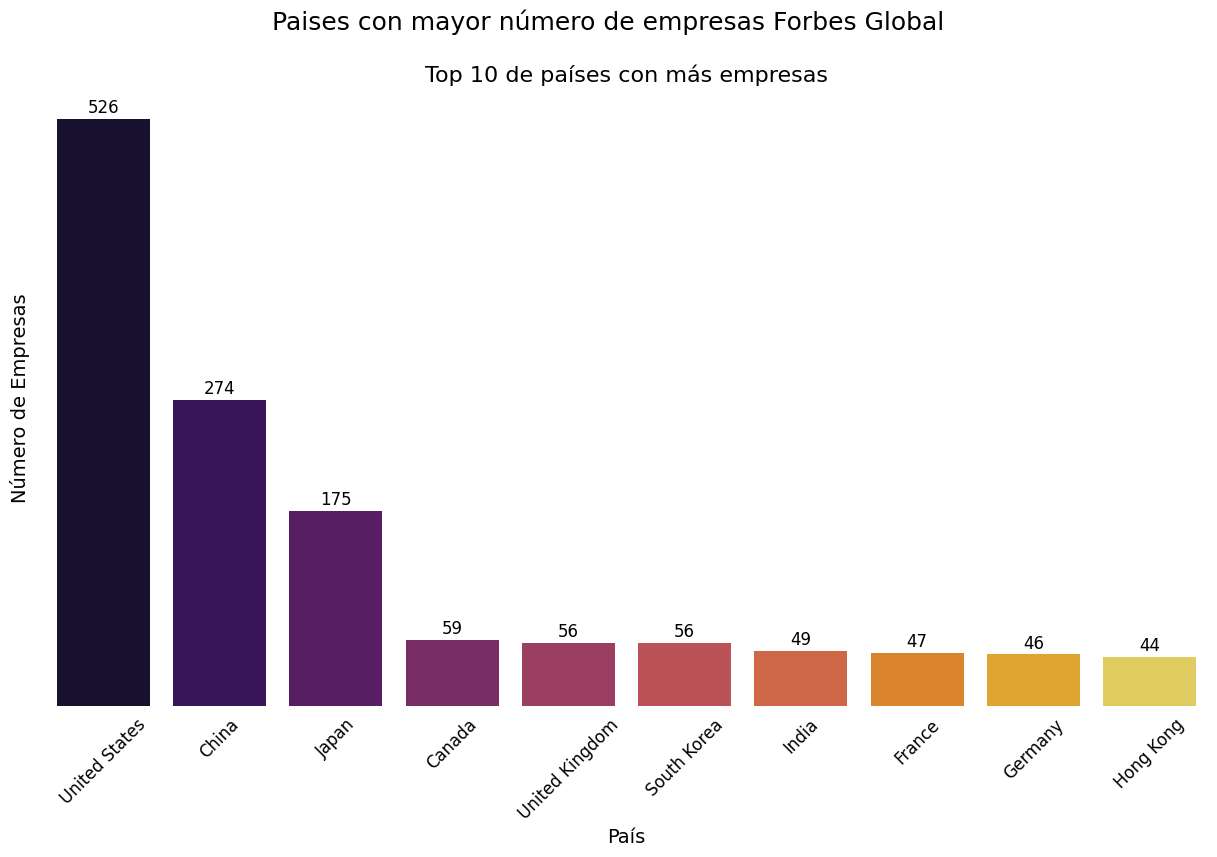

In [80]:
plt.figure(figsize=(15, 8))

ax = sns.barplot(x='Pais', y='Empresa',data=top_paises_con_mas_empresas,
                 hue='Pais', palette='inferno', legend=False)
plt.suptitle('Paises con mayor número de empresas Forbes Global', fontsize=18)
plt.title('Top 10 de países con más empresas', fontsize=16)
plt.xlabel('País', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.ylabel('Número de Empresas', fontsize=14)
ax.set_yticklabels([])
sns.despine(left=True,bottom=True)
ax.tick_params(left=False, bottom=False)

for i,j in enumerate(top_paises_con_mas_empresas['Empresa']):
    ax.text(i,j+10,str(j),color='black',fontsize=12,ha='center',va='center')


plt.show()

**Informe del Gráfico: Paises con mayor número de empresas Forbes Global (2022)**

Este gráfico de barras muestra el Top 10 de países con la mayor cantidad de empresas incluidas en el ranking Forbes Global del año 2022. Se observa que Estados Unidos lidera la lista con una cantidad significativamente mayor de empresas, seguido por China y Japón. Este gráfico resalta la concentración de grandes corporaciones a nivel global en estos países.

In [81]:
top_paises_empresas_tech

Pais Codigo  Empresa
0  United States    USA       18
1          China    CHN       13
2          Japan    JPN       11
3         Taiwan    TWN       10

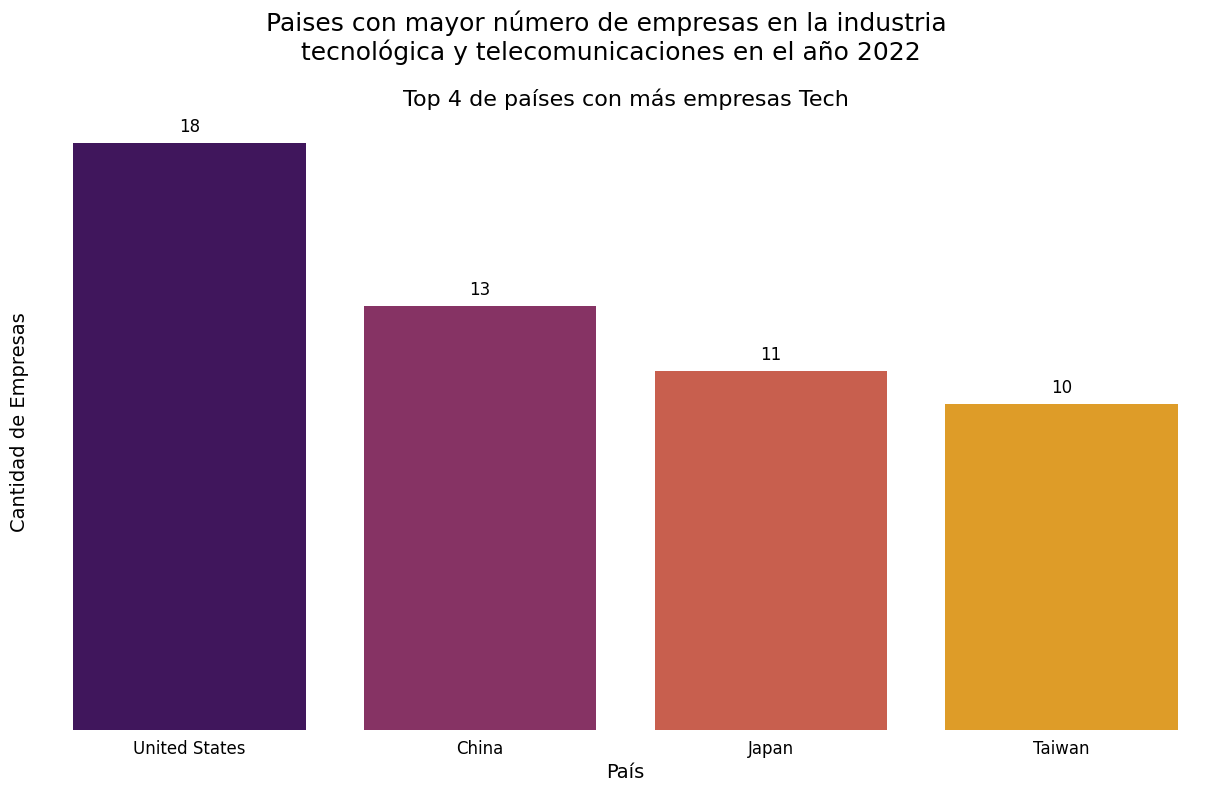

In [82]:
plt.figure(figsize=(15, 8))

ax = sns.barplot(x='Pais', y='Empresa', hue='Pais', data=top_paises_empresas_tech,
                 palette='inferno', legend=False)
plt.suptitle('Paises con mayor número de empresas en la industria\n tecnológica y telecomunicaciones en el año 2022',
             fontsize=18, y=1.01)
plt.title('Top 4 de países con más empresas Tech', fontsize=16)
plt.xlabel('País', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Cantidad de Empresas', fontsize=14)
for i,j in enumerate(top_paises_empresas_tech['Empresa']):
    ax.text(i,j+.5,str(j),color='black',fontsize=12,ha='center',va='center')

ax.set_yticklabels([])
sns.despine(left=True,bottom=True)
ax.tick_params(left=False, bottom=False)


plt.show()

**Informe del Gráfico: Paises con mayor número de empresas en la industria tecnológica y telecomunicaciones (2022)**

Este gráfico de barras presenta el Top 4 de países con la mayor cantidad de empresas en las áreas de tecnología y telecomunicaciones según el ranking Forbes Global 2022. Similar al ranking general, Estados Unidos y China ocupan los primeros lugares, lo que indica su dominio en estas industrias estratégicas. Japón y Taiwan también figuran en este top, mostrando su relevancia en el sector tecnológico.

In [83]:
top_empresas_margen_perdida

Empresa  Margen_de_rentabilidad (%)
0   Carnival Corporation                     -268.65
1        Las Vegas Sands                      -22.70
2  Caesars Entertainment                      -10.75
3  Flutter Entertainment                       -6.89
4                Aramark                        0.25

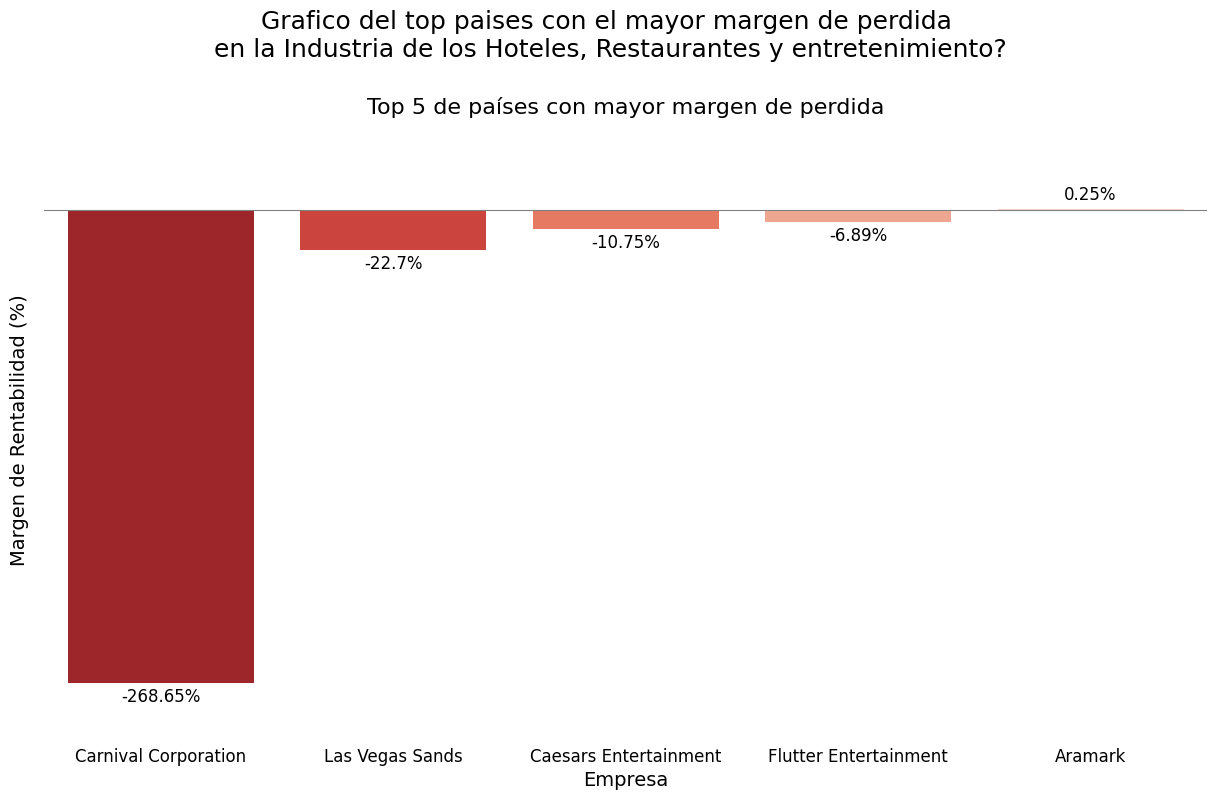

In [84]:
plt.figure(figsize=(15, 8))

ax = sns.barplot(x='Empresa', y='Margen_de_rentabilidad (%)', hue='Empresa',
                 data=top_empresas_margen_perdida, palette='Reds_r', legend=False)
plt.suptitle('Grafico del top paises con el mayor margen de perdida\n en la Industria de los Hoteles, Restaurantes y entretenimiento?',
             fontsize=18, y=1.02)
plt.title('Top 5 de países con mayor margen de perdida', fontsize=16)
plt.xlabel('Empresa', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Margen de Rentabilidad (%)', fontsize=14)
plt.ylim(-300,50)
ax.set_yticklabels([])
sns.despine(left=True,bottom=True)
plt.axhline(0, color='grey', linewidth=0.8)
for i,j in enumerate(top_empresas_margen_perdida['Margen_de_rentabilidad (%)']):
    ax.text(i,j-8 if j < 0 else j + 8,str(j) + '%',color='black',fontsize=12,ha='center',va='center')

ax.tick_params(left=False, bottom=False)


plt.show()

**Informe del Gráfico: Margen de Rentabilidad de las Empresas en la Industria de Hoteles, Restaurantes y Entretenimiento (2022)**

Este gráfico de barras muestra el margen de rentabilidad de las 5 empresas con mayores pérdidas en la industria de Hoteles, Restaurantes y Entretenimiento en el ranking Forbes Global 2022. Se observa que Carnival Corporation presentó el mayor margen de pérdida, seguido por Las Vegas Sands y Caesars Entertainment. Esto refleja el impacto negativo que enfrentaron estas empresas en el año 2022.

In [85]:
margen_rentabilidad_Asia

Empresa  Margen_de_rentabilidad (%)
0                                     CNOOC                       28.87
1                            ADNOC Drilling                       26.62
2  Saudi Arabian Oil Company (Saudi Aramco)                       26.32
3                           Adani Total Gas                       21.93
4                                GAIL India                       13.90
5                                   Towngas                        9.37
6                         Oil & Natural Gas                        9.06

In [86]:
margen_rentabilidad_Asia.loc[margen_rentabilidad_Asia['Empresa'] == 'Saudi Arabian Oil Company (Saudi Aramco)', 'Empresa'] = 'Saudi Aramco'
display(margen_rentabilidad_Asia['Empresa'])

0                CNOOC
1       ADNOC Drilling
2         Saudi Aramco
3      Adani Total Gas
4           GAIL India
5              Towngas
6    Oil & Natural Gas
Name: Empresa, dtype: object

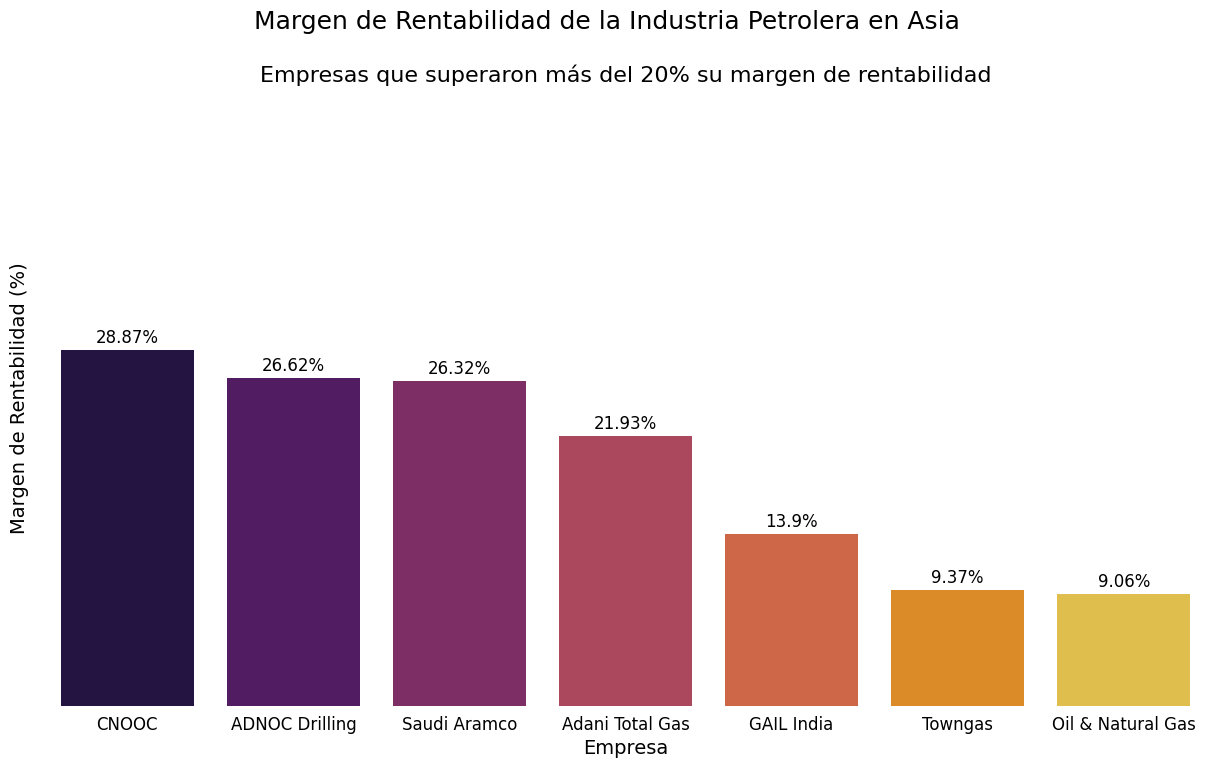

In [87]:
plt.figure(figsize=(15, 8))

ax = sns.barplot(x='Empresa', y='Margen_de_rentabilidad (%)', hue='Empresa',
                 data=margen_rentabilidad_Asia, palette='inferno', legend=False)

plt.suptitle('Margen de Rentabilidad de la Industria Petrolera en Asia', fontsize=18)
plt.title('Empresas que superaron más del 20% su margen de rentabilidad', fontsize=16)
plt.xlabel('Empresa', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Margen de Rentabilidad (%)', fontsize=14)
plt.ylim(0,50)
ax.set_yticklabels([])
sns.despine(left=True,bottom=True)

for i,j in enumerate(margen_rentabilidad_Asia['Margen_de_rentabilidad (%)']):
    ax.text(i,j+1,str(j) + '%',color='black',fontsize=12,ha='center',va='center')

ax.tick_params(left=False, bottom=False)


plt.show()

**Informe del Gráfico: Margen de Rentabilidad de la Industria Petrolera en Asia (2022)**

Este gráfico de barras presenta las empresas de la industria petrolera en Asia que superaron en más del 20% su margen de rentabilidad según el ranking Forbes Global 2022. Empresas como Novatek, Surgutneftegas y CNOOC destacan con altos márgenes de rentabilidad, lo que sugiere un año favorable para estas compañías en el sector petrolero asiático.

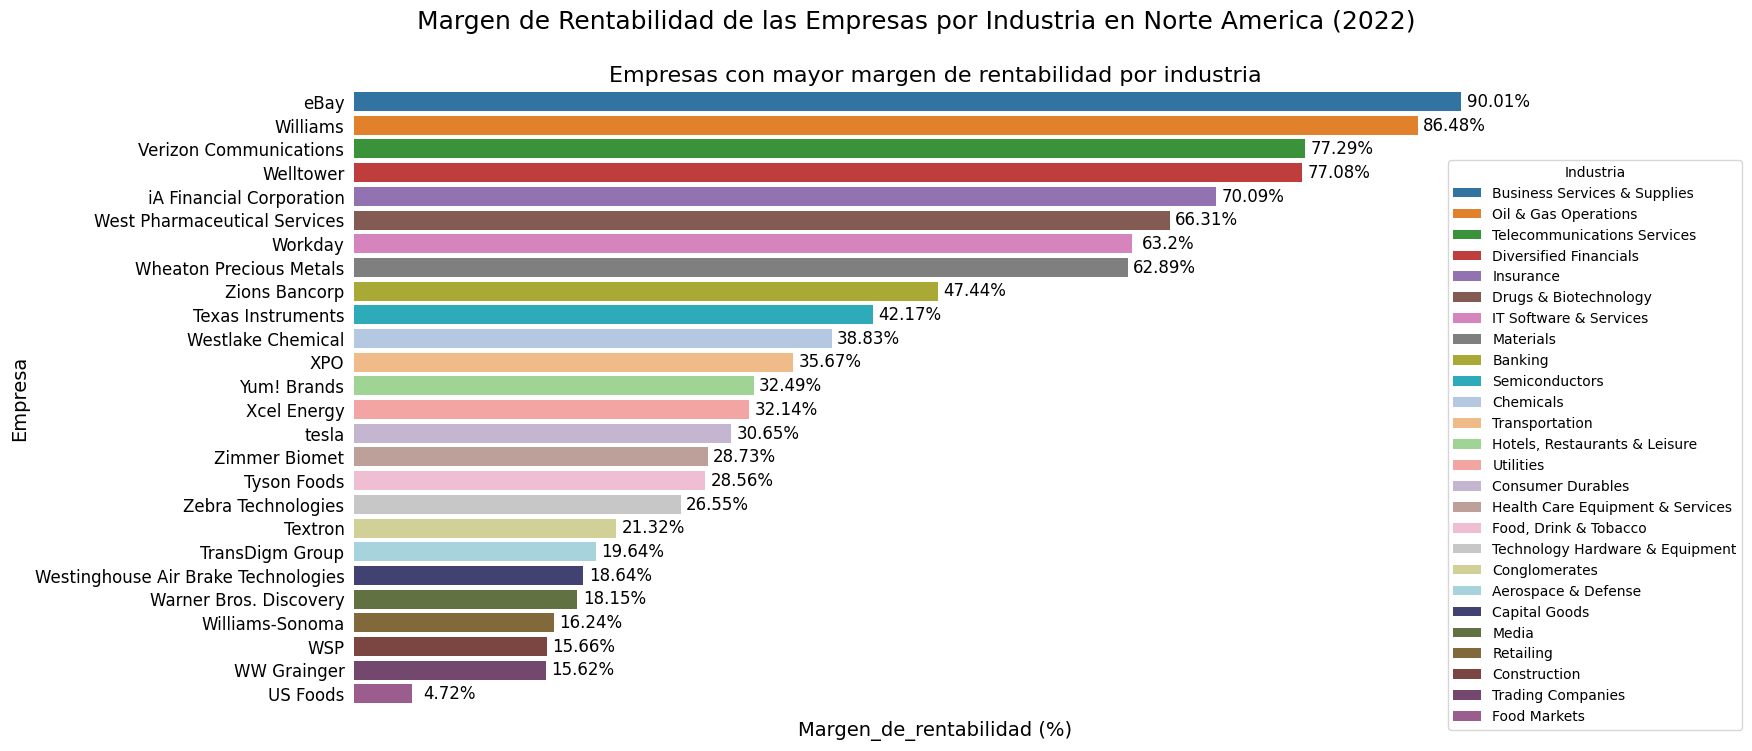

In [88]:
plt.figure(figsize=(15, 8))

# Define una paleta de colores personalizada
colores_personalizados = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
    '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5',
    '#393b79', '#637939', '#8c6d31', '#843c39', '#7b4173',
    '#a55194'
]


ax = sns.barplot(x='Margen_de_rentabilidad (%)', y='Empresa', hue='Industria',
                 data=empresas_NA_top_rentabilidad, orient='h', palette=colores_personalizados)

plt.suptitle('Margen de Rentabilidad de las Empresas por Industria en Norte America (2022)', fontsize=18)
plt.title('Empresas con mayor margen de rentabilidad por industria', fontsize=16)
plt.xlabel('Margen_de_rentabilidad (%)', fontsize=14)
plt.ylabel('Empresa', fontsize=14)
plt.yticks(fontsize=12)
ax.set_xticklabels([])
sns.despine(left=True,bottom=True)
ax.legend(bbox_to_anchor=(1.2,-0.05), bbox_transform=ax.transAxes,
          fontsize=10, loc='lower right', title='Industria')

for i,j in enumerate(empresas_NA_top_rentabilidad['Margen_de_rentabilidad (%)']):
    ax.text(j+3,i,str(j) + '%',color='black',fontsize=12,ha='center',va='center')

ax.tick_params(left=False, bottom=False)


plt.show()

**Informe del Gráfico: Margen de Rentabilidad de las Empresas por Industria en Norte América (2022)**

Este gráfico de barras horizontal exhibe las empresas norteamericanas con el mayor porcentaje de rentabilidad por industria en el ranking Forbes Global 2022. Se puede observar la diversidad de industrias representadas y cómo empresas individuales dentro de cada sector lograron altos márgenes de rentabilidad en Norteamérica durante este año.

In [89]:
empresas_EU_top_perdidas.head()

Industria    Empresa  Ganancias
0  Telecommunications Services   BT Group   -10188.7
1               Transportation       Aena    -3886.4
2       IT Software & Services       ATOS    -3501.0
3                    Insurance  AXA Group    -1984.9
4                 Construction    Acciona    -1149.0

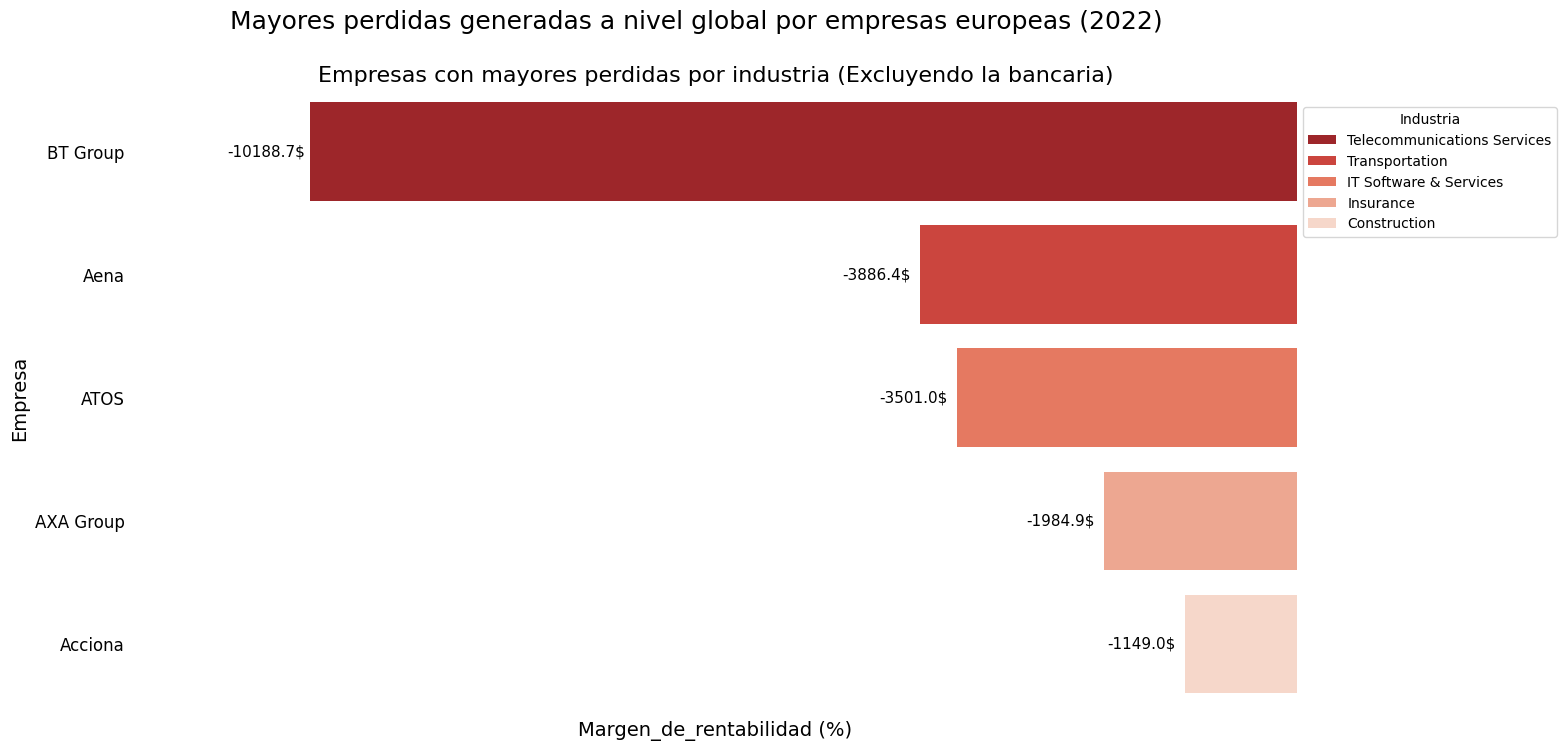

In [90]:
plt.figure(figsize=(15, 8))

ax = sns.barplot(x='Ganancias', y='Empresa', hue='Industria',
                 data=empresas_EU_top_perdidas.head(), palette='Reds_r', orient='h')

plt.suptitle('Mayores perdidas generadas a nivel global por empresas europeas (2022)',
             fontsize=18)
plt.title('Empresas con mayores perdidas por industria (Excluyendo la bancaria)',
          fontsize=16)
plt.xlabel('Margen_de_rentabilidad (%)', fontsize=14)
plt.ylabel('Empresa', fontsize=14)
plt.yticks(fontsize=12)
plt.xlim(-12000,0)
ax.set_xticklabels([])
sns.despine(left=True,bottom=True)

ax.legend(bbox_to_anchor=(1.23,0.75), bbox_transform=ax.transAxes,
          fontsize=10, loc='lower right', title='Industria')

for i,j in enumerate(empresas_EU_top_perdidas['Ganancias'].head()):
    ax.text(j-450, i, str(j) + '$', color='black',fontsize=11,ha='center',va='center')

ax.tick_params(left=False, bottom=False)


plt.show()

**Informe del Gráfico: Mayores pérdidas generadas a nivel global por empresas europeas (2022)**

Este gráfico de barras horizontal ilustra las empresas europeas (excluyendo la industria bancaria) que registraron las mayores pérdidas a nivel global en el ranking Forbes Global 2022. BT Group en telecomunicaciones y Aena en transporte se destacan con las mayores pérdidas, lo que indica desafíos significativos en estos sectores para las empresas europeas.

In [91]:
bancos_dist_activos_ingresos

Ingresos   Activos  Ganancias
3723   22507.0  280163.0     5107.1
3751   28331.0  296888.0     4066.9
3774   21887.0  226393.0     3011.0
3894    8626.0  243488.0     3377.4
3914    8251.0  272347.0     3314.6
...        ...       ...        ...
5328     700.0   48354.0       53.5
5338    1379.0   32958.0      587.0
5340     535.0   47632.0       82.2
5341    1317.0   39400.0      531.0
5344    2002.0   47441.0      426.0

[189 rows x 3 columns]

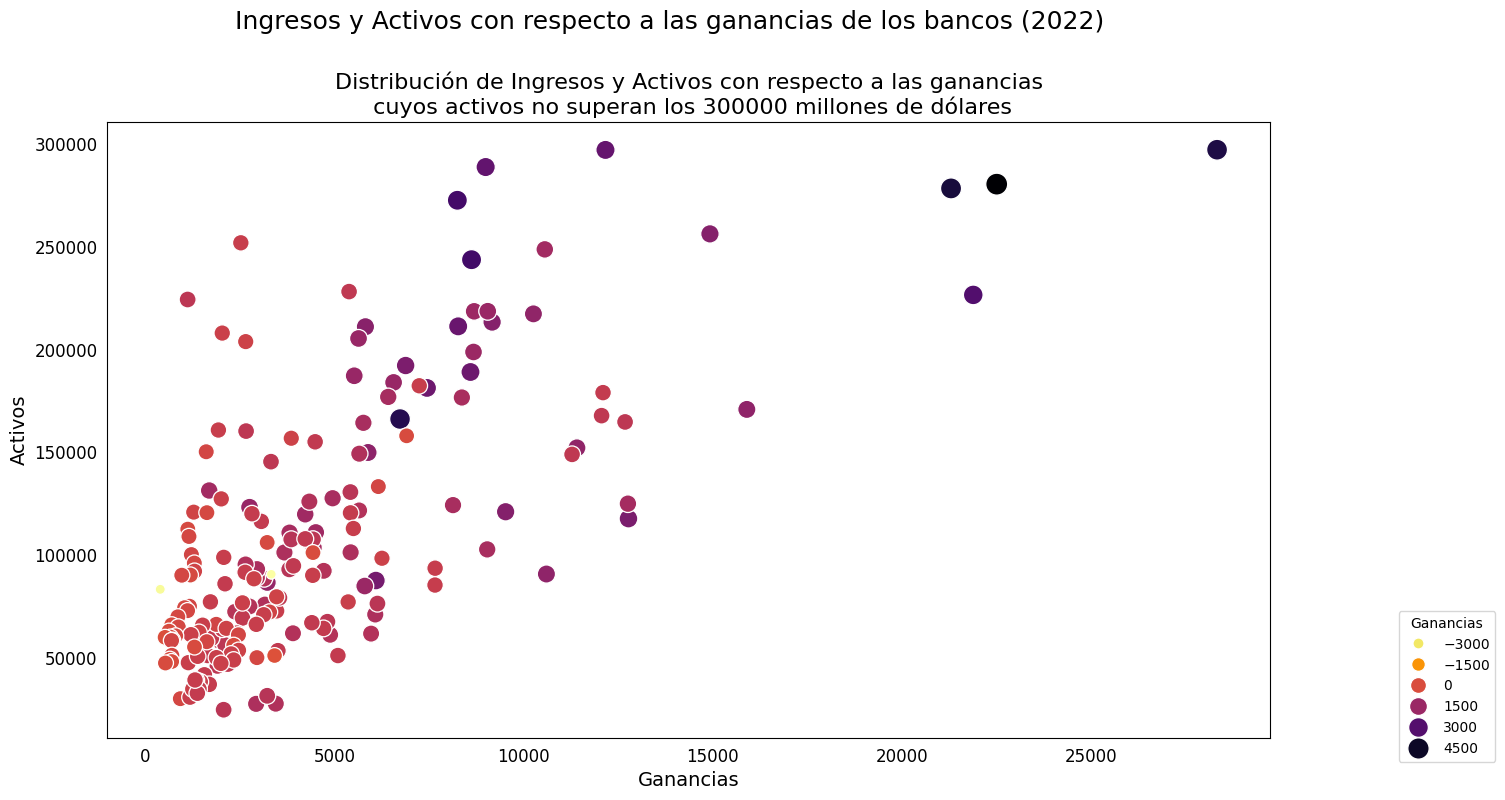

In [92]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.scatterplot(x='Ingresos', y='Activos', data=bancos_dist_activos_ingresos, size='Ganancias',  sizes=(50, 250), palette='inferno_r', hue='Ganancias')

plt.suptitle('Ingresos y Activos con respecto a las ganancias de los bancos (2022)', fontsize=18, y=1.02)
plt.title('Distribución de Ingresos y Activos con respecto a las ganancias\n cuyos activos no superan los 300000 millones de dólares', fontsize=16)
plt.xlabel('Ganancias', fontsize=14)
plt.ylabel('Activos', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

ax.legend(bbox_to_anchor=(1.2,-0.05), bbox_transform=ax.transAxes,
          fontsize=10, loc='lower right', title='Ganancias')

ax.tick_params(left=False, bottom=False)


plt.show()

**Informe del Gráfico: Distribución de Ingresos y Activos con respecto a las ganancias de los bancos (2022)**

Este gráfico de dispersión muestra la distribución de Ingresos y Activos en relación con las ganancias de los bancos con activos que no superan los 30,000 millones de dólares en el ranking Forbes Global 2022. El tamaño de los puntos representa los ingresos. Se puede observar la relación entre estas tres métricas para los bancos más pequeños.

In [93]:
df_massive.head()

Symbol      Fecha  Precio_Apertura  Precio_Cierre  Precio_Maximo  \
0  NTDOF 2024-01-02           53.040        51.3485         53.040   
1  NTDOF 2024-01-03           51.010        51.0000         51.568   
2  NTDOF 2024-01-04           51.129        49.7500         51.410   
3  NTDOF 2024-01-05           49.930        50.5000         50.653   
4  NTDOF 2024-01-08           52.260        50.8200         52.260   

   Precio_Minimo  Semana  
0         50.610       1  
1         50.965       1  
2         48.600       1  
3         49.880       1  
4         50.220       2

In [94]:
df_massive_semanal.head()

Symbol  Semana      Fecha  Precio_Apertura_Promedio  Precio_Cierre_Promedio  \
0     EA       1 2024-01-02                   139.390              139.318333   
1     EA       2 2024-01-08                   137.126              137.494000   
2     EA       3 2024-01-16                   137.580              137.380000   
3     EA       4 2024-01-22                   138.708              138.592000   
4     EA       5 2024-01-29                   137.572              137.654000   

   Precio_Maximo_Semanal  Precio_Minimo_Semanal  
0               147.4900               135.0461  
1               138.7800               135.4350  
2               138.8600               135.6900  
3               140.1109               137.5400  
4               140.0000               133.5100

In [95]:
fig = px.line(df_massive, x='Fecha', y='Precio_Cierre', color='Symbol',
              title=f'Precio de cierre diario de las acciones<br>{df_massive["Symbol"].unique()}',
              labels={'Precio_Cierre': 'Precio de Cierre'}, width=1500, height=500)

fig.add_trace(go.Scatter(x=mejor_semana_venta['Fecha'], y=mejor_semana_venta['Precio_Cierre_Promedio'],
                         mode='markers', name='Mejor semana venta', marker=dict(size = 7,color='blue'),
                         hovertext=[f"Simbolo: {row['Symbol']}<br>Fecha: {row['Fecha'].strftime('%d-%m-%Y')}<br>Semana: {row['Semana']}<br>Precio: {row['Precio_Cierre_Promedio']:.2f}$"
                                    for index, row in mejor_semana_venta.iterrows()],
                         hoverinfo='text'))
fig.add_trace(go.Scatter(x=mejor_semana_compra['Fecha'], y=mejor_semana_compra['Precio_Cierre_Promedio'],
                         mode='markers', name='Mejor semana compra', marker=dict(size = 7,color='green'),
                         hovertext=[f"Simbolo: {row['Symbol']}<br>Fecha: {row['Fecha'].strftime('%d-%m-%Y')}<br>Semana: {row['Semana']}<br>Precio: {row['Precio_Cierre_Promedio']:.2f}$"
                                    for index, row in mejor_semana_compra.iterrows()],
                         hoverinfo='text'))

fig.show()

**Informe del Gráfico: Precio de cierre diario de las acciones (2024)**

Este gráfico de líneas interactivo muestra el precio de cierre diario de las acciones de las cinco empresas seleccionadas (NTDOF, EA, KONMY, SQNXF, UBSFF) a lo largo del año 2024. Se han añadido marcadores para indicar la "mejor semana para comprar" (precio mínimo semanal) en verde y la "mejor semana para vender" (precio máximo semanal) en azul para cada empresa, según los datos históricos de valores.

**Mejores Semanas para Comprar:**

EA: Semana 16, Fecha 2024-04-15, Precio de Cierre Promedio: 126.56<br>
KONMY: Semana 1, Fecha 2024-01-04, Precio de Cierre Promedio: 26.04<br>
NTDOF: Semana 17, Fecha 2024-04-22, Precio de Cierre Promedio: 48.29<br>
SQNXF: Semana 25, Fecha 2024-06-17, Precio de Cierre Promedio: 28.81<br>
UBSFF: Semana 49, Fecha 2024-12-02, Precio de Cierre Promedio: 12.23

**Mejores Semanas para Vender:**

EA: Semana 49, Fecha 2024-12-02, Precio de Cierre Promedio: 166.74<br>
KONMY: Semana 39, Fecha 2024-09-25, Precio de Cierre Promedio: 49.50<br>
NTDOF: Semana 50, Fecha 2024-12-09, Precio de Cierre Promedio: 60.45<br>
SQNXF: Semana 8, Fecha 2024-02-21, Precio de Cierre Promedio: 44.67<br>
UBSFF: Semana 7, Fecha 2024-02-16, Precio de Cierre Promedio: 26.09

##Graficos cuestionario B

In [96]:
top_paises_empresas_15_22

Pais Codigo  Empresa
0   United States    USA     4190
1           China    CHN     1725
2           Japan    JPN     1570
3  United Kingdom    GBR      573
4     South Korea     KR      453
5          France    FRA      419
6          Canada    CAN      405
7           India    IND      387
8       Hong Kong    HKG      374
9         Germany    DEU      370

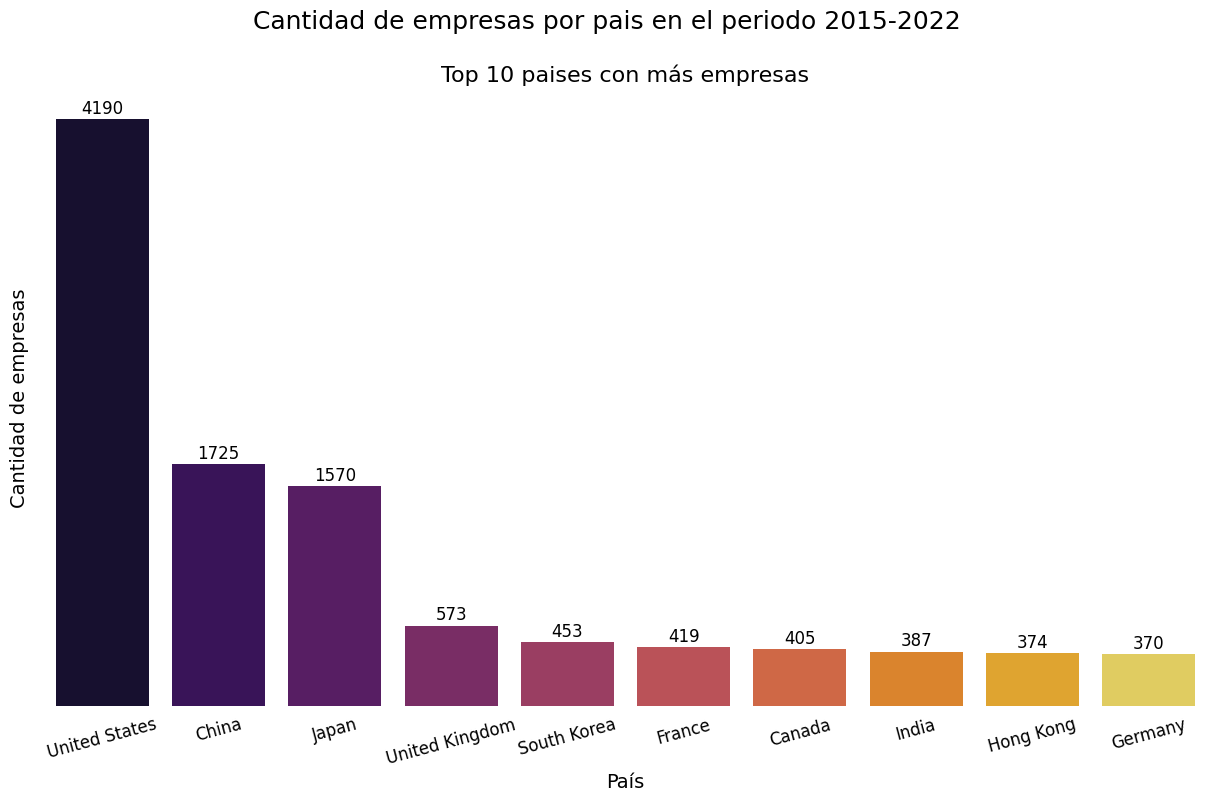

In [97]:
plt.figure(figsize=(15, 8))

ax = sns.barplot(x='Pais', y='Empresa', hue='Pais', data=top_paises_empresas_15_22,
                 palette='inferno', legend=False)

plt.suptitle('Cantidad de empresas por pais en el periodo 2015-2022', fontsize=18)
plt.title('Top 10 paises con más empresas', fontsize=16)
plt.xlabel('País', fontsize=14)
plt.xticks(fontsize=12, rotation=15)
plt.ylabel('Cantidad de empresas', fontsize=14)
ax.set_yticklabels([])
sns.despine(left=True,bottom=True)
for i,j in enumerate(top_paises_empresas_15_22['Empresa']):
    ax.text(i,j+75,str(j),color='black',fontsize=12,ha='center',va='center')

ax.tick_params(left=False, bottom=False)


plt.show()

**Informe del Gráfico: Cantidad de empresas por país en el periodo 2015-2022**

Este gráfico de barras presenta el Top 10 de países con la mayor cantidad de empresas incluidas en el ranking Forbes Global durante el periodo 2015-2022. De manera consistente con el año 2022, Estados Unidos, China y Japón mantienen su liderazgo en la concentración de grandes empresas a lo largo de estos años.

In [98]:
top_paises_empresas_tech_15_22

Pais Codigo  Empresa
0  United States    USA      144
1          China    CHN       82
2         Taiwan    TWN       67
3          Japan    JPN       66
4    South Korea     KR       34

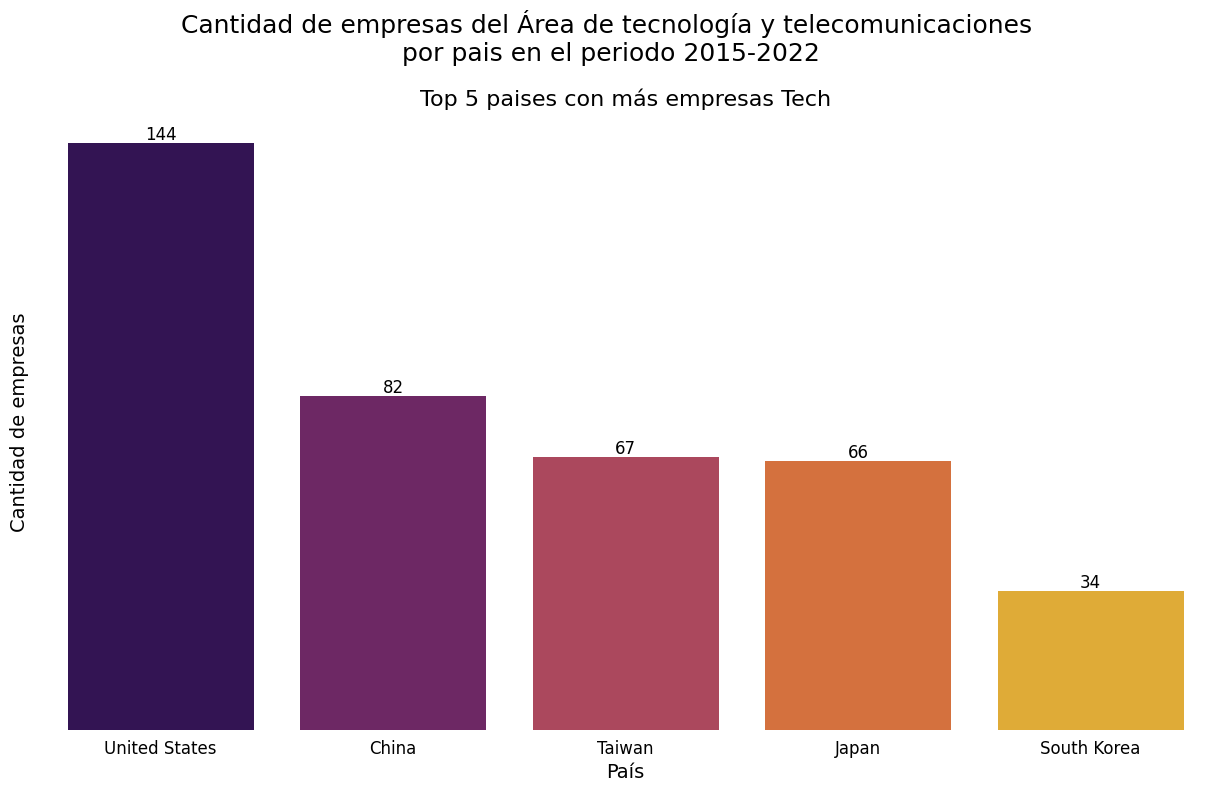

In [99]:
plt.figure(figsize=(15, 8))

ax = sns.barplot(x='Pais', y='Empresa', hue='Pais', data=top_paises_empresas_tech_15_22,
                 palette='inferno', legend=False)

plt.suptitle('Cantidad de empresas del Área de tecnología y telecomunicaciones\n por pais en el periodo 2015-2022', fontsize=18, y=1.01)
plt.title('Top 5 paises con más empresas Tech', fontsize=16)
plt.xlabel('País', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Cantidad de empresas', fontsize=14)
ax.set_yticklabels([])
sns.despine(left=True,bottom=True)
for i,j in enumerate(top_paises_empresas_tech_15_22['Empresa']):
    ax.text(i,j+2,str(j),color='black',fontsize=12,ha='center',va='center')

ax.tick_params(left=False, bottom=False)


plt.show()

**Informe del Gráfico: Cantidad de empresas del Área de tecnología y telecomunicaciones por país en el periodo 2015-2022**

Este gráfico de barras muestra el Top 5 de países con la mayor cantidad de empresas en las áreas de tecnología y telecomunicaciones en el ranking Forbes Global durante el periodo 2015-2022. Estados Unidos y China siguen siendo los principales actores, seguidos por Taiwan y Japón, lo que subraya su continua importancia en estos sectores a lo largo del tiempo.

In [100]:
top_perdidas_empresas_HRE

Empresa  Ganancias
0            Carnival Corporation    -9419.0
1           Royal Caribbean Group    -5797.5
2           Caesars Entertainment    -3970.6
3           Flutter Entertainment     -523.3
4         InterContinental Hotels      414.6
5                         Genting      481.7
6  Haidilao International Holding      635.8
7                    Wynn Resorts      707.0
8                  Domino's Pizza      921.0
9                 Las Vegas Sands     1008.0

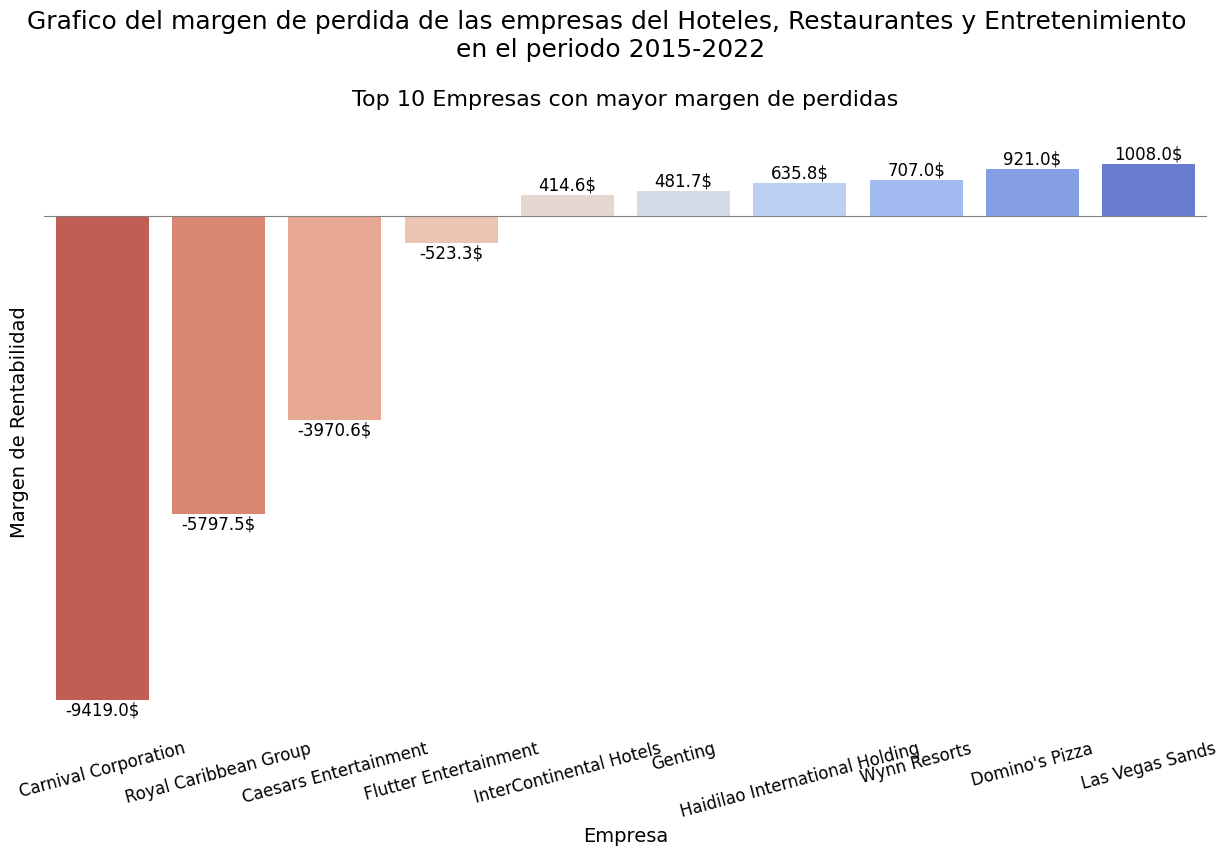

In [101]:
plt.figure(figsize=(15, 8))
colores = ['green' if v >= 0 else 'red' for v in top_perdidas_empresas_HRE['Ganancias']]

ax = sns.barplot(x='Empresa', y='Ganancias', hue='Empresa', data=top_perdidas_empresas_HRE, palette='coolwarm_r', legend=False)

plt.suptitle('Grafico del margen de perdida de las empresas del Hoteles, Restaurantes y Entretenimiento\n en el periodo 2015-2022', fontsize=18, y=1.01)
plt.title('Top 10 Empresas con mayor margen de perdidas', fontsize=16)
plt.xlabel('Empresa', fontsize=14)
plt.xticks(fontsize=12, rotation=15)
plt.ylabel('Margen de Rentabilidad', fontsize=14)
plt.ylim(-10000,2000)
plt.axhline(0, color='grey', linewidth=0.8)
ax.set_yticklabels([])
sns.despine(left=True,bottom=True)


for i,j in enumerate(top_perdidas_empresas_HRE['Ganancias']):
    ax.text(i,j-200 if j < 0 else j+200,str(j) + '$',color='black',fontsize=12,ha='center',va='center')

ax.tick_params(left=False, bottom=False)


plt.show()

**Informe del Gráfico: Margen de pérdida de las empresas del Hoteles, Restaurantes y Entretenimiento en el periodo 2015-2022**

Este gráfico de barras visualiza el margen de pérdida de las 10 empresas con mayores perjuicios en la industria de Hoteles, Restaurantes y Entretenimiento durante el periodo 2015-2022. Carnival Corporation y Royal Caribbean Group muestran las mayores pérdidas acumuladas en este sector a lo largo de los años indicados.

In [102]:
top_empresas_ROA

Empresa  ROA (%)
0  Weatherford International    49.84
1         Whitecap Resources    26.03

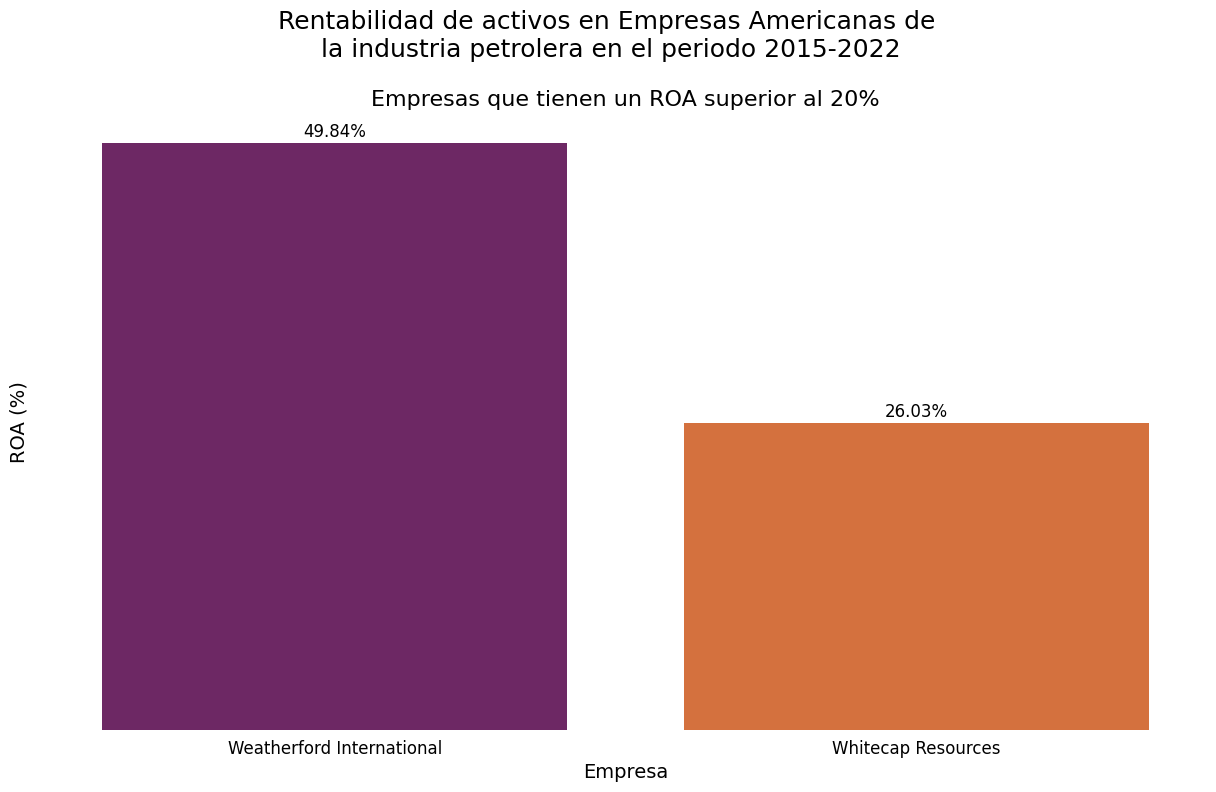

In [103]:
plt.figure(figsize=(15, 8))

ax = sns.barplot(x='Empresa', y='ROA (%)', data=top_empresas_ROA, hue='Empresa',
                 palette='inferno', legend=False)

plt.suptitle('Rentabilidad de activos en Empresas Americanas de\n la industria petrolera en el periodo 2015-2022', fontsize=18, y=1.01)
plt.title('Empresas que tienen un ROA superior al 20%', fontsize=16)
plt.xlabel('Empresa', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('ROA (%)', fontsize=14)
ax.set_yticklabels([])
sns.despine(left=True,bottom=True)

for i,j in enumerate(top_empresas_ROA['ROA (%)']):
    ax.text(i,j+1,str(j) + '%',color='black',fontsize=12,ha='center',va='center')

ax.tick_params(left=False, bottom=False)


plt.show()

**Informe del Gráfico: Rentabilidad de activos en Empresas Americanas de la industria petrolera en el periodo 2015-2022**

Este gráfico de barras presenta las empresas americanas de la industria petrolera que tuvieron una rentabilidad de activos (ROA) superior al 20% en promedio durante el periodo 2015-2022. Weatherford International y Whitecap Resources destacan con un ROA promedio superior a este umbral, indicando una gestión eficiente de sus activos para generar ganancias.

In [104]:
empresas_EU_top_rentabilidad

Industria                         Empresa  \
0              Food, Drink & Tobacco                       Südzucker   
1             Diversified Financials  Wuestenrot & Wuerttembergische   
2                          Chemicals              Yara International   
3                        Real Estate                 Unibail-Rodamco   
4             IT Software & Services                       Yandex NV   
5                       Construction                        Wolseley   
6   Health Care Equipment & Services                      bioMerieux   
7                  Consumer Durables                     Volvo Group   
8                            Banking                 Virgin Money UK   
9                          Utilities                         Verbund   
10     Hotels, Restaurants & Leisure                       Whitbread   
11             Drugs & Biotechnology                             UCB   
12              Oil & Gas Operations       Weatherford International   
13                         Insurance          Zurich Insurance Group   
14                     Conglomerates              Trane Technologies   
15                         Materials                     Voestalpine   
16                             Media                  Wolters Kluwer   
17       Telecommunications Services                        Vodafone   
18                    Transportation                           Vopak   
19       Diversified Metals & Mining                     Voestalpine   
20                     Capital Goods                        Wärtsilä   
21                    Semiconductors              STMicroelectronics   
22      Business Services & Supplies                        Wirecard   
23               Aerospace & Defense                Zodiac Aerospace   
24   Technology Hardware & Equipment                 TE Connectivity   
25                           Airline                Turkish Airlines   
26                         Retailing                         Zalando   
27                 Trading Companies                           Rexel   
28                      Food Markets                 X5 Retail Group   
29                       Air Courier                      Royal Mail   

    Margen_de_rentabilidad (%)  
0                       100.00  
1                        98.13  
2                        92.84  
3                        92.39  
4                        91.30  
5                        85.15  
6                        81.46  
7                        78.17  
8                        77.77  
9                        66.40  
10                       61.85  
11                       57.78  
12                       55.93  
13                       53.51  
14                       52.19  
15                       50.71  
16                       46.52  
17                       45.71  
18                       45.58  
19                       45.48  
20                       39.67  
21                       34.03  
22                       28.30  
23                       25.80  
24                       25.30  
25                       24.10  
26                       16.66  
27                        8.17  
28                        6.26  
29                        4.60

/tmp/ipython-input-2462450902.py:3: UserWarning:


The palette list has fewer values (26) than needed (29) and will cycle, which may produce an uninterpretable plot.



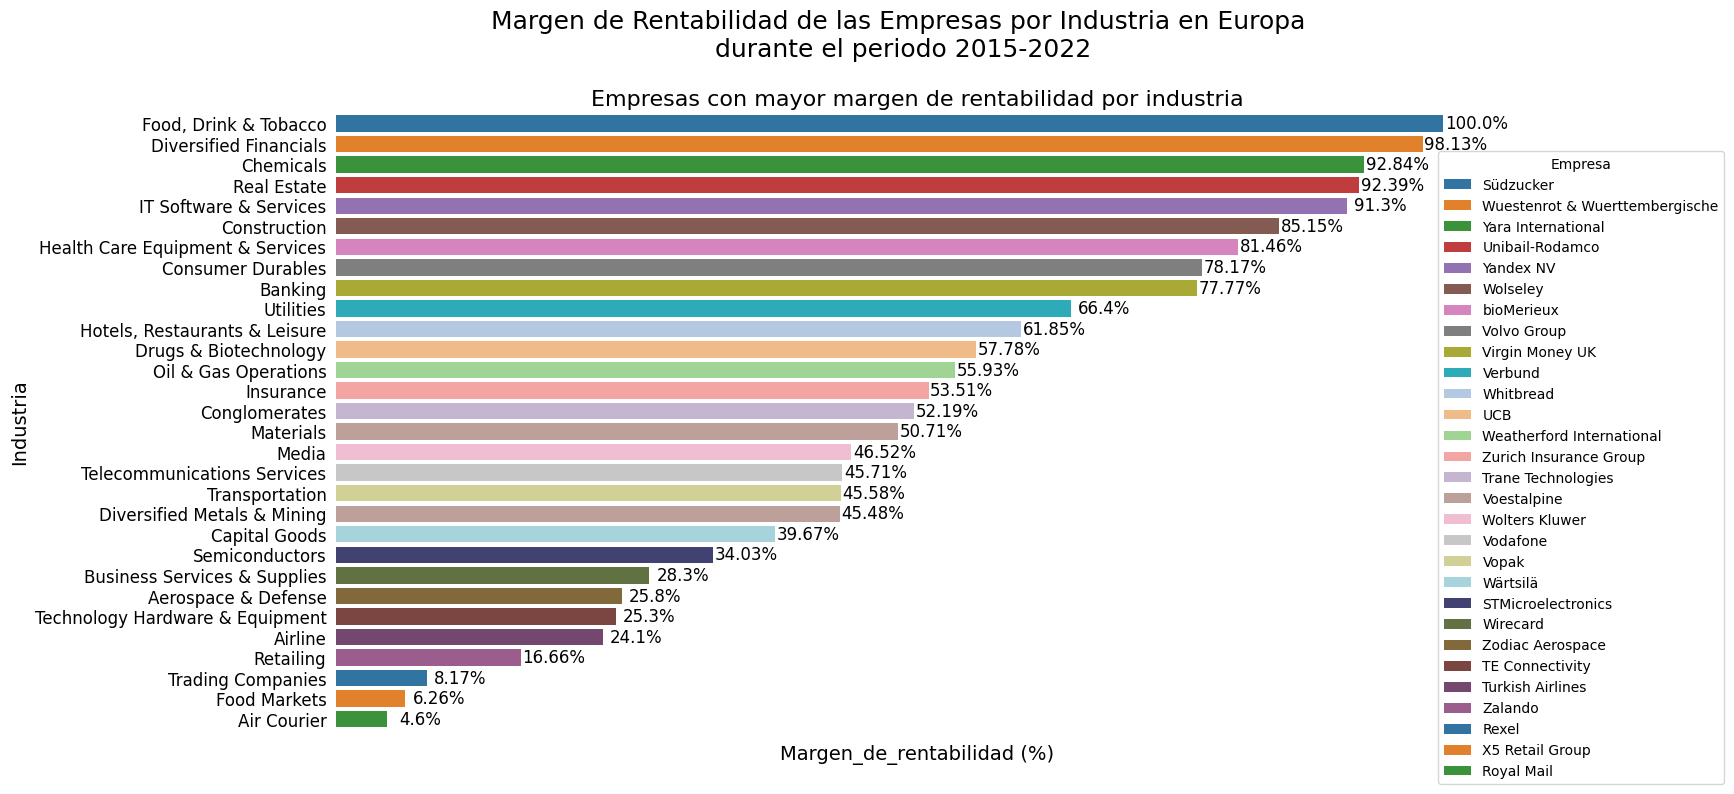

In [105]:
plt.figure(figsize=(15, 8))

ax = sns.barplot(x='Margen_de_rentabilidad (%)', y='Industria', hue='Empresa', data=empresas_EU_top_rentabilidad, orient='h', palette=colores_personalizados)

plt.suptitle('Margen de Rentabilidad de las Empresas por Industria en Europa\n durante el periodo 2015-2022', fontsize=18, y=1.01)
plt.title('Empresas con mayor margen de rentabilidad por industria', fontsize=16)
plt.xlabel('Margen_de_rentabilidad (%)', fontsize=14)
plt.ylabel('Industria', fontsize=14)
plt.yticks(fontsize=12)

ax.set_xticklabels([])
sns.despine(left=True,bottom=True)
ax.legend(bbox_to_anchor=(1.2,-0.1), bbox_transform=ax.transAxes,
          fontsize=10, loc='lower right', title='Empresa')

for i,j in enumerate(empresas_EU_top_rentabilidad['Margen_de_rentabilidad (%)']):
    ax.text(j+3,i,str(j) + '%',color='black',fontsize=12,ha='center',va='center')

ax.tick_params(left=False, bottom=False)

plt.show()

**Informe del Gráfico: Margen de Rentabilidad de las Empresas por Industria en Europa durante el periodo 2015-2022**

Este gráfico de barras horizontal exhibe el margen de rentabilidad de las empresas europeas con el mayor porcentaje de rentabilidad por industria durante el periodo 2015-2022. Se observa la diversidad de industrias y las empresas líderes en rentabilidad dentro de cada sector en Europa a lo largo de estos años.

In [106]:
empresas_NA_top_perdidas

Industria        Empresa  Ganancias
0           Oil & Gas Operations  AGL Resources   -23119.0
1                  Conglomerates             3M   -22367.0
2                 Transportation     Air Canada   -13028.0
3    Diversified Metals & Mining          Alcoa   -12204.0
4            Aerospace & Defense    BAE Systems   -11873.0
5  Hotels, Restaurants & Leisure        Aramark   -11427.0
6          Food, Drink & Tobacco   Altria Group   -10229.0
7          Drugs & Biotechnology         AbbVie    -9015.0
8         IT Software & Services          Adobe    -8506.0
9                      Utilities            AES    -7642.0

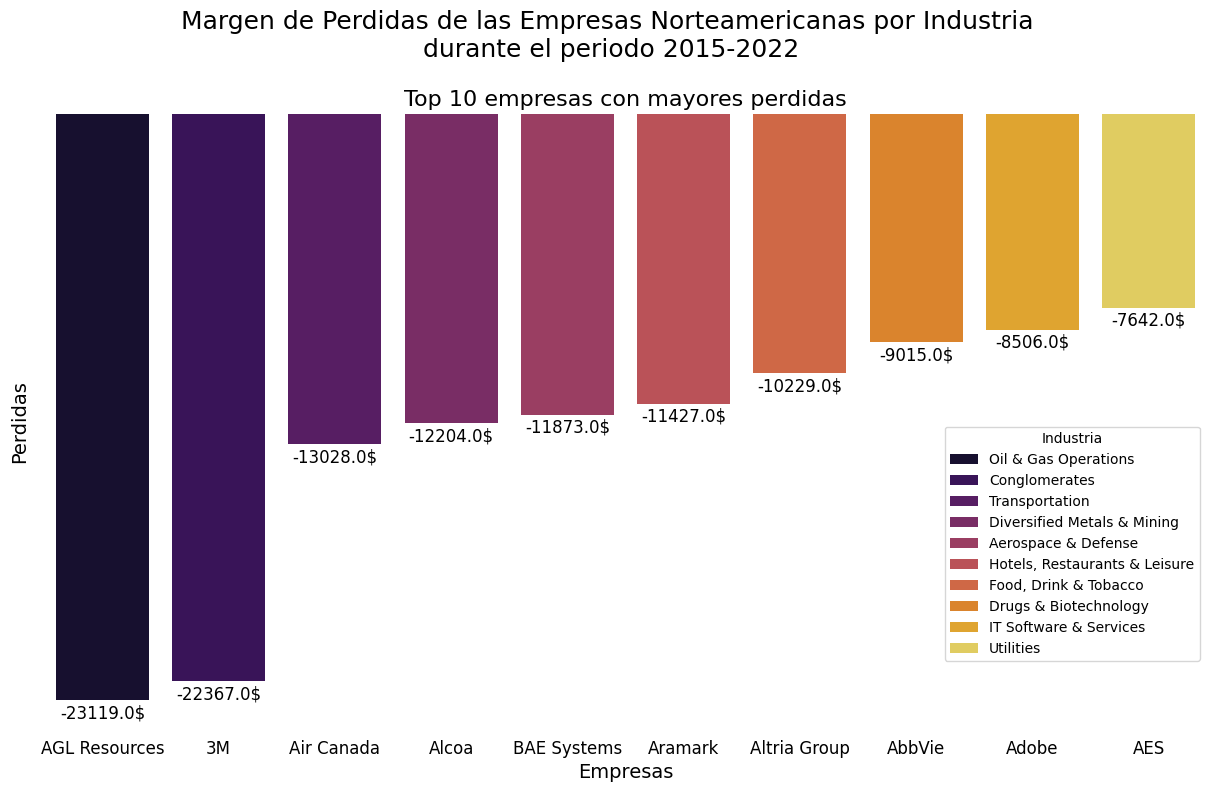

In [107]:
plt.figure(figsize=(15, 8))

ax = sns.barplot(x='Empresa', y='Ganancias', hue='Industria', data=empresas_NA_top_perdidas, palette='inferno')

plt.suptitle('Margen de Perdidas de las Empresas Norteamericanas por Industria\n durante el periodo 2015-2022', fontsize=18, y=1.01)
plt.title('Top 10 empresas con mayores perdidas', fontsize=16)
plt.xlabel('Empresas', fontsize=14)
plt.ylabel('Perdidas', fontsize=14)
plt.xticks(fontsize=12)
ax.set_yticklabels([])
sns.despine(left=True,bottom=True)
ax.legend(bbox_to_anchor=(1,0.1), bbox_transform=ax.transAxes,
          fontsize=10, loc='lower right', title='Industria')

for i,j in enumerate(empresas_NA_top_perdidas['Ganancias']):
    ax.text(i,j-500,str(j) + '$',color='black',fontsize=12,ha='center',va='center')

ax.tick_params(left=False, bottom=False)


plt.show()

**Informe del Gráfico: Margen de Perdidas de las Empresas Norteamericanas por Industria durante el periodo 2015-2022**

Este gráfico de barras muestra las 10 empresas norteamericanas con las mayores pérdidas registradas por industria a nivel global durante el periodo 2015-2022. Empresas en sectores como Oil & Gas Operations, Conglomerates y Transportation figuran entre las que experimentaron mayores pérdidas en este periodo.

In [108]:
bancos_dist_activos_ingresos_15_22

Ingresos   Activos  Ganancias
0      14249.0  124813.0     1947.7
1       8413.0   84337.0     1446.8
2       6050.0  133565.0     2871.2
3       8349.0   84585.0     1862.3
4       6073.0  130371.0     1168.6
...        ...       ...        ...
1432    3717.0   15308.0      407.3
1433     427.0   28318.0       96.9
1434    1171.0   28063.0      216.8
1435     555.0   27948.0      131.4
1436     523.0   27941.0       71.1

[1437 rows x 3 columns]

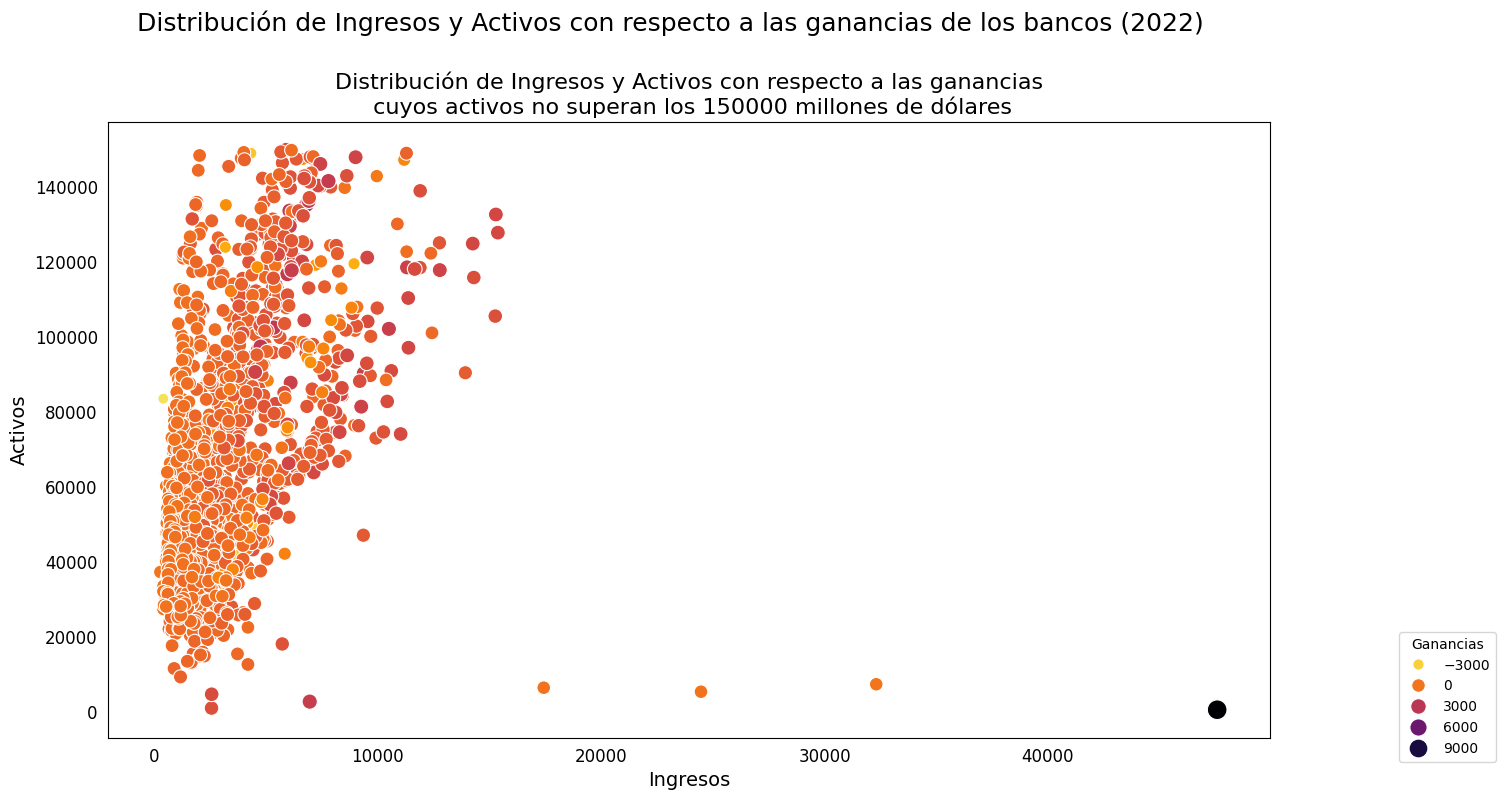

In [109]:
plt.figure(figsize=(15, 8))

ax = sns.scatterplot(x='Ingresos', y='Activos', data=bancos_dist_activos_ingresos_15_22, size='Ganancias', hue='Ganancias', sizes=(50, 200), palette='inferno_r')

plt.suptitle('Distribución de Ingresos y Activos con respecto a las ganancias de los bancos (2022)', fontsize=18, y=1.02)
plt.title('Distribución de Ingresos y Activos con respecto a las ganancias\n cuyos activos no superan los 150000 millones de dólares', fontsize=16)
plt.xlabel('Ingresos', fontsize=14)
plt.ylabel('Activos', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.legend(bbox_to_anchor=(1.2,-0.05), bbox_transform=ax.transAxes,
          fontsize=10, loc='lower right', title='Ganancias')

ax.tick_params(left=False, bottom=False)


plt.show()

**Informe del Gráfico: Distribución de Ingresos y Activos con respecto a las ganancias de los bancos (2015-2022)**

Este gráfico de dispersión muestra la distribución de Ingresos y Activos en relación con las ganancias de los bancos con activos que no superan los 15,000 millones de dólares durante el periodo 2015-2022. El tamaño de los puntos representa los ingresos. Permite visualizar la relación entre estas métricas para los bancos más pequeños a lo largo de los años.

##Extra

##Gráfico de carrera de barras: Variación del valor de mercado por industria durante el periodo 2015 - 2022

In [110]:
df_forbes_2015_2022.head()

Rank_nr                     Empresa               Industria           Pais  \
0       1                        ICBC                 Banking          China   
1       2     China Construction Bank                 Banking          China   
2       3  Agricultural Bank of China                 Banking          China   
3       4               Bank of China                 Banking          China   
4       5          Berkshire Hathaway  Diversified Financials  United States   

   Ingresos  Ganancias    Activos  Valor_de_mercado  \
0  166796.0    44757.2  3322043.0          278327.0   
1  130473.0    37038.9  2698925.0          212945.0   
2  129221.0    29124.5  2574815.0          189879.0   
3  120297.0    27526.8  2458336.0          199130.0   
4  194673.0    19872.0   534618.0          354813.0   

   Margen_de_rentabilidad (%)  ROA (%)   Ano Codigo     Continente  
0                       26.83     1.35  2015    CHN           Asia  
1                       28.39     1.37  2015    CHN           Asia  
2                       22.54     1.13  2015    CHN           Asia  
3                       22.88     1.12  2015    CHN           Asia  
4                       10.21     3.72  2015    USA  North America

In [111]:
df_valor_mercado_industria = df_forbes_2015_2022.groupby(['Industria','Ano'])[['Valor_de_mercado']].sum().reset_index()

display(df_valor_mercado_industria)

Industria   Ano  Valor_de_mercado
0    Aerospace & Defense  2015          495998.0
1    Aerospace & Defense  2016          461814.0
2    Aerospace & Defense  2017          569080.0
3    Aerospace & Defense  2018          823629.0
4    Aerospace & Defense  2019          774962.0
..                   ...   ...               ...
223            Utilities  2018         1453548.0
224            Utilities  2019         1464050.2
225            Utilities  2020         1436273.0
226            Utilities  2021         1798762.0
227            Utilities  2022         1759061.0

[228 rows x 3 columns]

In [112]:
df_valor_mercado_wide = df_valor_mercado_industria.pivot(index='Ano', columns='Industria', values='Valor_de_mercado')
display(df_valor_mercado_wide)

Industria  Aerospace & Defense  Air Courier        Airline    Banking  \
Ano                                                                     
2015                  495998.0     182440.0  231569.000000  6428752.0   
2016                  461814.0     189408.0  234571.000000  5424851.0   
2017                  569080.0     199831.0  266658.000000  6331748.0   
2018                  823629.0     229597.0  288824.666667  7358965.0   
2019                  774962.0          NaN            NaN  6208171.6   
2020                  634564.0          NaN            NaN  4367629.0   
2021                  786779.0          NaN            NaN  5984434.0   
2022                  825865.0          NaN            NaN  6250852.0   

Industria  Business Services & Supplies  Capital Goods  Casinos & Gaming  \
Ano                                                                        
2015                           827123.0      1006417.0           97872.0   
2016                           800595.0       777653.0           76383.0   
2017                          1049012.0       935143.0           82803.0   
2018                          1000515.0      1143665.0          162448.0   
2019                          1947020.0      1024941.7               NaN   
2020                          2161008.0       928666.0               NaN   
2021                          3399771.0      1889540.0               NaN   
2022                          2368522.0      1513047.0               NaN   

Industria  Chemicals  Conglomerates  Construction  ...      Media  \
Ano                                                ...              
2015       1214169.0      1106287.0      789453.0  ...  1231424.0   
2016       1079241.0      1135099.0      765159.0  ...  1033466.0   
2017       1186212.0      1130146.0      936321.0  ...  1088928.0   
2018       1422781.5      1002357.0      989199.0  ...   981624.0   
2019       1216777.0       996009.0     1448270.8  ...   987691.0   
2020        955205.0       766680.0     1296967.0  ...   699983.0   
2021       1465857.0      1192157.0     1660876.0  ...  1431005.0   
2022       1573412.0      1035368.0     1347424.0  ...   979214.0   

Industria  Oil & Gas Operations  Real Estate  Retailing  Semiconductors  \
Ano                                                                       
2015                  3724039.0     875061.0  1780080.0       1079328.0   
2016                  3181699.0     929983.0  1748836.0        945210.0   
2017                  3420546.0     959551.0  1819856.0       1272126.0   
2018                  4094917.0    1094982.0  2833309.0       1833943.0   
2019                  3794763.0          NaN  3142449.6       1493620.0   
2020                  3950487.0          NaN  3509258.0       1715790.0   
2021                  4789270.0          NaN  5091864.0       3128352.0   
2022                  6369776.0          NaN  4182062.0       3104857.0   

Industria  Technology Hardware & Equipment  Telecommunications Services  \
Ano                                                                       
2015                             1258466.0                    2101099.0   
2016                             1072760.0                    2081288.0   
2017                             1210384.0                    1973037.0   
2018                             1571013.0                    1944172.0   
2019                             2456234.1                    1930886.0   
2020                             2629448.0                    1709939.0   
2021                             4484954.0                    1954841.0   
2022                             4340170.0                    1719039.0   

Industria  Trading Companies  Transportation  Utilities  
Ano                                                      
2015                142170.0        682239.0  1331239.0  
2016                132402.0        661160.0  1287075.0  
2017                160716.0        753602.0  1380553.0  
2018                20568

In [113]:
# con esto llenamos los valores nulos con el primer o ultimo valor no nulo, segun convenga
# Esto para evitar columnas superpuestas, producto de como maneja la libreria las columnas
# con valores nulos

df_valor_mercado_wide.ffill(inplace=True)
df_valor_mercado_wide.bfill(inplace=True)

display(df_valor_mercado_wide)

Industria  Aerospace & Defense  Air Courier        Airline    Banking  \
Ano                                                                     
2015                  495998.0     182440.0  231569.000000  6428752.0   
2016                  461814.0     189408.0  234571.000000  5424851.0   
2017                  569080.0     199831.0  266658.000000  6331748.0   
2018                  823629.0     229597.0  288824.666667  7358965.0   
2019                  774962.0     229597.0  288824.666667  6208171.6   
2020                  634564.0     229597.0  288824.666667  4367629.0   
2021                  786779.0     229597.0  288824.666667  5984434.0   
2022                  825865.0     229597.0  288824.666667  6250852.0   

Industria  Business Services & Supplies  Capital Goods  Casinos & Gaming  \
Ano                                                                        
2015                           827123.0      1006417.0           97872.0   
2016                           800595.0       777653.0           76383.0   
2017                          1049012.0       935143.0           82803.0   
2018                          1000515.0      1143665.0          162448.0   
2019                          1947020.0      1024941.7          162448.0   
2020                          2161008.0       928666.0          162448.0   
2021                          3399771.0      1889540.0          162448.0   
2022                          2368522.0      1513047.0          162448.0   

Industria  Chemicals  Conglomerates  Construction  ...      Media  \
Ano                                                ...              
2015       1214169.0      1106287.0      789453.0  ...  1231424.0   
2016       1079241.0      1135099.0      765159.0  ...  1033466.0   
2017       1186212.0      1130146.0      936321.0  ...  1088928.0   
2018       1422781.5      1002357.0      989199.0  ...   981624.0   
2019       1216777.0       996009.0     1448270.8  ...   987691.0   
2020        955205.0       766680.0     1296967.0  ...   699983.0   
2021       1465857.0      1192157.0     1660876.0  ...  1431005.0   
2022       1573412.0      1035368.0     1347424.0  ...   979214.0   

Industria  Oil & Gas Operations  Real Estate  Retailing  Semiconductors  \
Ano                                                                       
2015                  3724039.0     875061.0  1780080.0       1079328.0   
2016                  3181699.0     929983.0  1748836.0        945210.0   
2017                  3420546.0     959551.0  1819856.0       1272126.0   
2018                  4094917.0    1094982.0  2833309.0       1833943.0   
2019                  3794763.0    1094982.0  3142449.6       1493620.0   
2020                  3950487.0    1094982.0  3509258.0       1715790.0   
2021                  4789270.0    1094982.0  5091864.0       3128352.0   
2022                  6369776.0    1094982.0  4182062.0       3104857.0   

Industria  Technology Hardware & Equipment  Telecommunications Services  \
Ano                                                                       
2015                             1258466.0                    2101099.0   
2016                             1072760.0                    2081288.0   
2017                             1210384.0                    1973037.0   
2018                             1571013.0                    1944172.0   
2019                             2456234.1                    1930886.0   
2020                             2629448.0                    1709939.0   
2021                             4484954.0                    1954841.0   
2022                             4340170.0                    1719039.0   

Industria  Trading Companies  Transportation  Utilities  
Ano                                                      
2015                142170.0        682239.0  1331239.0  
2016                132402.0        661160.0  1287075.0  
2017                160716.0        753602.0  1380553.0  
2018                20568

In [114]:
# df_valor_mercado_wide.to_csv('valor_mercado_por_industria.csv', index=False)

In [115]:

warnings.filterwarnings('ignore')
# Guardamos el video en formato mp4 y lo mostramos en pantalla
bcr.bar_chart_race(df_valor_mercado_wide, 'valor_mercado_industria.mp4', fixed_max=True, steps_per_period=20, period_length=1000,
                   interpolate_period=True, figsize=(7,6), title='Valor de Mercado x Industria (2015-2019)', period_fmt='Año - {x:.0f}')

bcr.bar_chart_race(df_valor_mercado_wide, fixed_max=True, steps_per_period=20, period_length=1000,
                   interpolate_period=True, figsize=(7,6), title='Valor de Mercado x Industria (2015-2019)', period_fmt='Año - {x:.0f}')



**Informe del Gráfico: Carreras de Barras - Variación del valor de mercado por industria (2015-2019)**

Este gráfico de carreras de barras animado muestra la variación del valor de mercado total por industria en el ranking Forbes Global durante el periodo 2015-2019. Permite observar de forma dinámica cómo ha evolucionado el valor de mercado de las diferentes industrias a lo largo del tiempo, identificando las que han crecido o disminuido su valor.

In [116]:
df_forbes_empleados.head()

Rank_nr                     Empresa               Industria           Pais  \
0       2     China Construction Bank                 Banking          China   
1       3  Agricultural Bank of China                 Banking          China   
2       4               Bank of China                 Banking          China   
3       5          Berkshire Hathaway  Diversified Financials  United States   
4       7                 Exxon Mobil    Oil & Gas Operations  United States   

   Ingresos  Ganancias    Activos  Valor_de_mercado  \
0  130473.0    37038.9  2698925.0          212945.0   
1  129221.0    29124.5  2574815.0          189879.0   
2  120297.0    27526.8  2458336.0          199130.0   
3  194673.0    19872.0   534618.0          354813.0   
4  376240.0    32520.0   349493.0          357094.0   

   Margen_de_rentabilidad (%)  ROA (%)   Ano Codigo     Continente  Empleados  
0                       28.39     1.37  2015    CHN           Asia     372321  
1                       22.54     1.13  2015    CHN           Asia     505627  
2                       22.88     1.12  2015    CHN           Asia     308128  
3                       10.21     3.72  2015    USA  North America     316000  
4                        8.64     9.30  2015    USA  North America      83700

In [117]:
df_empleados_por_industria = df_forbes_empleados.groupby(['Ano','Industria'])[['Empleados']].sum().reset_index()

df_empleados_por_industria_wide = df_empleados_por_industria.pivot(index='Ano', columns='Industria', values='Empleados')

display(df_empleados_por_industria_wide)

Industria  Aerospace & Defense  Air Courier   Airline    Banking  \
Ano                                                                
2015                  571400.0     741883.0  276955.0  4532323.0   
2016                  638800.0     773543.0  285449.0  3947034.0   
2017                  552340.0     335767.0  294056.0  4216861.0   
2018                  549400.0     404336.0  302964.0  4143035.0   
2019                  541239.0          NaN       NaN  3355433.0   
2020                  802643.0          NaN       NaN  3603038.0   
2021                  714700.0          NaN       NaN  3377862.0   
2022                  621100.0          NaN       NaN  3364942.0   

Industria  Business Services & Supplies  Capital Goods  Chemicals  \
Ano                                                                 
2015                           269198.0       827923.0   298496.0   
2016                           718201.0       971679.0   170543.0   
2017                           931326.0       856686.0   178543.0   
2018                           506706.0       813360.0   322332.0   
2019                           378677.0       668151.0   207854.0   
2020                           253333.0       492756.0   253114.0   
2021                           196519.0       657942.0   205436.0   
2022                           375864.0       667689.0   278174.0   

Industria  Conglomerates  Construction  Consumer Durables  ...     Media  \
Ano                                                        ...             
2015           2032965.0     1077717.0          4617432.0  ...  344600.0   
2016           1673946.0     1215266.0          5093033.0  ...  198300.0   
2017           1633484.0     1282366.0          5022566.0  ...  297000.0   
2018           1691036.0     1323256.0          5131477.0  ...  329800.0   
2019           2021257.0     1727215.0          4697273.0  ...  483000.0   
2020           1708619.0     1698889.0          3400498.0  ...  413000.0   
2021           1534451.0     1863427.0          3574405.0  ...  476500.0   
2022           1616647.0     1679810.0          4114432.0  ...  465000.0   

Industria  Oil & Gas Operations  Real Estate  Retailing  Semiconductors  \
Ano                                                                       
2015                  1676929.0          NaN  1611706.0        488591.0   
2016                  1383977.0      42295.0  2405336.0        459300.0   
2017                   999113.0     297680.0  2302187.0        461500.0   
2018                  1562377.0     408821.0  4550823.0        451371.0   
2019                  1175543.0          NaN  4749313.0        176400.0   
2020                  1358777.0          NaN  5202541.0        162097.0   
2021                  1211596.0          NaN  5915478.0        204285.0   
2022                  1496062.0          NaN  6001421.0        269604.0   

Industria  Technology Hardware & Equipment  Telecommunications Services  \
Ano                                                                       
2015                              703374.0                     892456.0   
2016                              763796.0                     916234.0   
2017                              900882.0                     897133.0   
2018                              869686.0                     852151.0   
2019                             1841556.0                     927802.0   
2020                             1223421.0                     890353.0   
2021                             1693775.0                     878421.0   
2022                              954895.0                     726055.0   

Industria  Trading Companies  Transportation  Utilities  
Ano                                                      
2015                157980.0        134187.0   565250.0  
2016                203938.0        133584.0   530952.0  
2017                421818.0         85834.0   515116.0  
2018                498931.0         86389.0   516627.0  
2019             

In [118]:
# con esto llenamos los valores nulos con el primer o ultimo valor no nulo, segun convenga
# Esto para evitar columnas superpuestas, producto de como maneja la libreria las columnas
# con valores nulos

df_empleados_por_industria_wide.ffill(inplace=True)
df_empleados_por_industria_wide.bfill(inplace=True)

df_empleados_por_industria_wide.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 2015 to 2022
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Aerospace & Defense               8 non-null      float64
 1   Air Courier                       8 non-null      float64
 2   Airline                           8 non-null      float64
 3   Banking                           8 non-null      float64
 4   Business Services & Supplies      8 non-null      float64
 5   Capital Goods                     8 non-null      float64
 6   Chemicals                         8 non-null      float64
 7   Conglomerates                     8 non-null      float64
 8   Construction                      8 non-null      float64
 9   Consumer Durables                 8 non-null      float64
 10  Diversified Financials            8 non-null      float64
 11  Diversified Metals & Mining       8 non-null      float64
 12  Drugs & Bio

In [119]:
# df_empleados_por_industria_wide.to_csv('empleados_por_industria.csv', index=False)

In [120]:
# Guardamos el video en formato mp4 y lo mostramos en pantalla

bcr.bar_chart_race(df_empleados_por_industria_wide, 'Empleados_por_industria.mp4', fixed_max=True, steps_per_period=20, period_length=1000,
                   interpolate_period=True, figsize=(7,6), title='Numero de Empleados x Industria (2015-2019)',
                   period_fmt='Año - {x:.0f}')


bcr.bar_chart_race(df_empleados_por_industria_wide, fixed_max=True, steps_per_period=20, period_length=1000,
                   interpolate_period=True, figsize=(7,6), title='Numero de Empleados x Industria (2015-2019)',
                   period_fmt='Año - {x:.0f}')

**Informe del Gráfico: Carreras de Barras - Número de Empleados por Industria (2015-2019)**

Este gráfico de carreras de barras animado visualiza la variación en el número total de empleados por industria según el ranking Forbes Global durante el periodo 2015-2019. Este gráfico dinámico permite observar los cambios en el tamaño de la fuerza laboral en las diferentes industrias a lo largo del tiempo.

In [121]:
df_forbes_2022.head()

Rank_nr                                   Empresa  \
3573       1                        Berkshire Hathaway   
3574       2                                      ICBC   
3575       3  Saudi Arabian Oil Company (Saudi Aramco)   
3576       4                            JPMorgan Chase   
3577       5                   China Construction Bank   

                   Industria           Pais  Ingresos  Ganancias    Activos  \
3573  Diversified Financials  United States  276094.0    89795.0   958784.0   
3574                 Banking          China  208127.0    54028.3  5518508.0   
3575    Oil & Gas Operations   Saudi Arabia  400376.0   105363.0   576041.0   
3576  Diversified Financials  United States  124542.0    42115.0  3954687.0   
3577                 Banking          China  202069.0    46887.3  4746951.0   

      Valor_de_mercado  Margen_de_rentabilidad (%)  ROA (%)   Ano Codigo  \
3573          741476.0                       32.52     9.37  2022    USA   
3574          214425.0                       25.96     0.98  2022    CHN   
3575         2292077.0                       26.32    18.29  2022    SAU   
3576          374446.0                       33.82     1.06  2022    USA   
3577          181325.0                       23.20     0.99  2022    CHN   

         Continente  
3573  North America  
3574           Asia  
3575           Asia  
3576  North America  
3577           Asia

In [122]:
df_ventas_globales = df_forbes_2022.groupby(['Pais','Codigo'])[['Ingresos']].sum().reset_index()

display(df_ventas_globales.head())

Pais Codigo  Ingresos
0  Argentina    ARG   13019.0
1  Australia    AUS  389945.0
2    Austria    AUT  119977.0
3    Bahrain    BHR    1565.0
4    Belgium    BEL  132333.0

In [123]:
df_ventas_globales.to_csv('ventas_globales.csv',index=False)

In [124]:
plt.figure(figsize=(15, 8))

fig = px.choropleth(df_ventas_globales, locations="Codigo",
                    color="Ingresos",
                    hover_name="Pais",
                    hover_data={'Ingresos':':.2f'},
                    color_continuous_scale=px.colors.sequential.Inferno,
                    title='Total de Ventas Globales x País (2022)')


fig.show()

<Figure size 1500x800 with 0 Axes>